In [1]:
import collections
from datetime import datetime as dt
from datetime import timedelta
from edgar import Company
import graphviz
import json
import lxml.html as lh
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pandas_datareader as pdr
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import re
import requests
import sec_scraper
import statsmodels.api as sm
from sklearn import metrics, preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
import time
import warnings
from yellowbrick.regressor import ResidualsPlot
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 100
plotly.offline.init_notebook_mode()
warnings.filterwarnings('ignore')

/Users/alandu/Documents/Resume/2020/AngelList/Fig/figpython/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



In [2]:
# Functions for getting the CIK and Company Name from a SPAC ticker

def get_ticker_to_cik(write=False):
    # local copy: data/ticker_to_cik.txt
    ticker_to_cik = pd.read_csv('https://www.sec.gov/include/ticker.txt',
                                sep='\t', header=None, names=['ticker','cik'])
    if write:
        ticker_to_cik.to_csv('data/ticker_to_cik.csv', index=False)
    ticker_to_cik['ticker'] = ticker_to_cik.ticker.str.upper()
    ticker_to_cik['cik'] = ticker_to_cik.cik.astype(str)
    return ticker_to_cik

def get_cik_to_name(write=False):
    # local copy: data/cik_to_name.json
    cik_to_name = requests.get('https://www.sec.gov/files/company_tickers.json')
    cik_to_name = json.dumps(cik_to_name.json())
    cik_to_name = pd.read_json(cik_to_name).transpose()
    cik_to_name['ticker'] = cik_to_name['ticker'].str.upper()
    cik_to_name['cik_str'] = cik_to_name['cik_str'].astype(str)
    cik_to_name.rename(columns={'cik_str':'cik'}, inplace=True)
    return cik_to_name

def update_current_spacs(file_path_current, write=False):
    df_traq = pd.read_csv('https://docs.google.com/spreadsheets/d/14BY8snyHMbUReQVRgZxv4U4l1ak79dWFIymhrLbQpSo/'
                             'export?gid=0&format=csv', header=2)
    df_traq.columns = [x.replace('\n','') for x in df_traq.columns]
    df_spacs_existing = pd.read_csv(file_path_current)
    df_spacs_existing.drop_duplicates(inplace=True)
    combined_spacs = df_spacs_existing['Ticker'].append(df_traq['Issuer Symbol'])
    df_spacs_new = pd.DataFrame(combined_spacs, columns=['Ticker'])
    df_spacs_new.drop_duplicates(inplace=True)
    df_spacs_new.reset_index(inplace=True, drop=True)
    new_added_tickers = [x for x in df_spacs_new['Ticker'].tolist()
                         if x not in df_spacs_existing['Ticker'].tolist()]
    if len(new_added_tickers) > 0:
        print('newly added tickers:', new_added_tickers)
    if write:
        df_spacs_new.to_csv(file_path_current, index=False)
    return

def process_current_spacs(file_path_current, write=False):
    # current spac list
    spac_list_current = pd.read_csv(file_path_current)
    spac_list_current = spac_list_current.Ticker.unique()
    spac_list_current = pd.DataFrame(spac_list_current, columns=['Ticker'])
    
    # write to file
    if write==True:
        spac_list_current.to_csv('spac_list_current.csv', index=False)
        
    # get ticker to cik and cik to company name file, then merge
    ticker_to_cik = get_ticker_to_cik(write=write)
    cik_to_name = get_cik_to_name(write=write)
    spac_list_current = spac_list_current.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    spac_list_current = spac_list_current.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    
    # some current spacs have not split from units to stock + warrants so ticker in sec different
    ticker_unit = pd.DataFrame(spac_list_current[spac_list_current.ticker.isna()]['Ticker'])
    ticker_unit['Ticker'] = ticker_unit.Ticker + 'U'
    ticker_unit = ticker_unit.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    ticker_unit = ticker_unit.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    ticker_unit['Ticker'] = ticker_unit.Ticker.apply(lambda x: x[:-1] if not pd.isnull(x) else x)
    ticker_unit['ticker'] = ticker_unit.ticker.apply(lambda x: x[:-1] if not pd.isnull(x) else x)
    ticker_unit_other = pd.DataFrame(ticker_unit[ticker_unit.ticker.isna()]['Ticker'])
    ticker_unit_other['Ticker'] = ticker_unit_other.Ticker.apply(lambda x: x+'-UN')
    ticker_unit_other = ticker_unit_other.merge(ticker_to_cik, how='left', left_on='Ticker', right_on='ticker')
    ticker_unit_other = ticker_unit_other.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])
    ticker_unit_other['Ticker'] = ticker_unit_other.Ticker.apply(lambda x: x[:-3] if not pd.isnull(x) else x)
    ticker_unit_other['ticker'] = ticker_unit_other.ticker.apply(lambda x: x[:-3] if not pd.isnull(x) else x)
    ticker_unit = ticker_unit.append(ticker_unit_other)
    ticker_unit.dropna(inplace=True)
    
    # append tickers found using 'U' and '-UN'
    spac_list_current = spac_list_current[~spac_list_current.Ticker.isin(ticker_unit.Ticker)]
    spac_list_current = spac_list_current.append(ticker_unit)
    
    print('count current spacs:', len(spac_list_current))
    print('count nan in current spacs:', len(spac_list_current[spac_list_current.ticker.isna()]))
    
    return spac_list_current
    
def process_past_spacs(file_path_past, write=False):
    # past spac list (completed business combination)
    spac_list_past = pd.read_csv(file_path_past)
    spac_list_past.fillna('missing', inplace=True)
    spac_list_past['dupe_filter'] = spac_list_past['Old Ticker'] + spac_list_past['New Ticker']
    spac_list_past = spac_list_past[spac_list_past.dupe_filter.isin(spac_list_past.dupe_filter.unique())]
    spac_list_past.drop(columns=['dupe_filter'], inplace=True)
    
    # write to file
    if write==True:
        spac_list_past.to_csv('spac_list_past.csv', index=False)
        
    # get ticker to cik and cik to company name file, then merge
    ticker_to_cik = get_ticker_to_cik(write=write)
    cik_to_name = get_cik_to_name(write=write)
    spac_list_past = spac_list_past.merge(ticker_to_cik, how='left', left_on='New Ticker', right_on='ticker')
    spac_list_past = spac_list_past.merge(ticker_to_cik, how='left', left_on='Old Ticker', right_on='ticker')
    spac_list_past.rename(columns={'ticker_x':'ticker','cik_x':'cik','cik_y':'cik_old'}, inplace=True)
    spac_list_past.drop(columns='ticker_y', inplace=True)
    spac_list_past = spac_list_past.merge(cik_to_name[['cik','ticker','title']], how='left', on=['cik','ticker'])

    print('count past spacs:', len(spac_list_past))
    print('count nan in past spacs:', len(spac_list_past[spac_list_past.ticker.isna()]))
    
    return spac_list_past

In [3]:
# Functions for pulling 8-K html, converting to text, grabbing date, and simple text match classifier

def basic_text_cleaning(text):
    text = text.replace('\n',' ').replace('\xa0',' ') # replace some unicode characters
    text = re.sub(' +', ' ', text) # remove extra spaces
    text = text.lower()
    return text

def get_forms_text(company_name, cik_id, form_type):
    c = sec_scraper.Company(company_name, cik_id, timeout=30)
    filings = c.get_all_filings(filing_type=form_type, no_of_documents=100)
    dates = [f.accepted_date.strftime('%Y-%m-%d %H:%M:%S') for f in filings]
    documents = [basic_text_cleaning(f.documents[0]) for f in filings]
    urls = [f.url for f in filings]
    print(company_name, cik_id)
    df = pd.DataFrame(list(zip(dates, documents, urls)), columns=['date','text','url'])
    df['form'] = '8-K'
    df['accepted_time'] = df.date
    df['date'] = df.date.apply(lambda x: x[0:10])
    df['url'] = df.url
    return df

def basic_text_match(df_form, substring):
    df_form[substring.replace(' ','_')+'_found'] = df_form.text.apply(lambda x: 1 if substring in x else 0)
    return df_form

In [4]:
# Functions for grabbing and saving price data

def bulk_save_prices_to_csv(symbols, start_date, end_date, price_source, is_warrant=False):
    for ind, symbol in enumerate(symbols):
        print(symbol)
        df_prices = get_historical_prices(symbol=symbol,
                                          start_date=start_date,
                                          end_date=end_date,
                                          price_source=price_source,
                                          is_warrant=is_warrant)
        if df_prices is not None:
            df_prices = process_historical_prices(df_prices)
            df_prices = df_prices[[col for col in df_prices.columns if '%chg' not in col]]
            df_prices.to_csv('data/prices_'+price_source+'/daily_data/'+symbol+'_prices.csv', index=False)
        # TD and alphavantage limits query rate
        if ind%10==0 and ind!=0:
            time.sleep(30)
        
def run_bulk_save_daily_prices(spac_list_current, spac_list_past, price_source, is_warrant=False):
    # spacs missing price data entirely
    missing_past_spacs = ['missing', 'LCAH', 'FMCI1', 'CFCO']
    missing_current_spacs = ['ACNDU', 'BRLI', 'DFHT', 'DMYD', 'GOAC', 'IWAC',
                             'LCAH', 'MCAC', 'PANA', 'PSAC', 'PSTH', 'SSMC']
    
    symbols_past_new_ticker = [x for x in spac_list_past.ticker.unique().tolist() if str(x)!='nan']
    symbols_past_old_ticker = spac_list_past['Old Ticker'].unique().tolist()
    symbols_past_old_ticker = [x for x in symbols_past_old_ticker if x not in missing_past_spacs]
    symbols_current = [x for x in spac_list_current['Ticker'] if x not in missing_current_spacs]
    if is_warrant:
        symbols_past_new_ticker = [x + 'W' for x in symbols_past_new_ticker]
        symbols_past_old_ticker = [x + 'W' for x in symbols_past_old_ticker]
        symbols_current = [x + 'W' for x in symbols_current]
    bulk_save_prices_to_csv(symbols=symbols_past_new_ticker, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)
    bulk_save_prices_to_csv(symbols=symbols_past_old_ticker, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)
    bulk_save_prices_to_csv(symbols=symbols_current, start_date='2018-01-01',
                            end_date=dt.today().strftime('%Y-%m-%d'), price_source=price_source, is_warrant=is_warrant)

def get_td_key_locally():
    f = open("data/td_consumer_key.txt", "r")
    return f.read()

def millis_since_epoch_to_dt(x):
    return dt.fromtimestamp(float(x)/1000).strftime('%Y-%m-%d %H:%M:%S.%f')

def dt_to_millis_since_epoch(x):
    epoch = dt.utcfromtimestamp(0)
    return str(int((x-epoch).total_seconds()*1000))

def get_prices_td(symbol, start_date, end_date, minute_freq=False):
    TD_CONSUMER_KEY = get_td_key_locally()
    start_date_epoch = dt_to_millis_since_epoch(dt.strptime(start_date, '%Y-%m-%d'))
    end_date_epoch = dt_to_millis_since_epoch(dt.strptime(end_date, '%Y-%m-%d'))
    partial_url = 'https://api.tdameritrade.com/v1/marketdata/{symbol}/pricehistory?'
    # minute-to-minute prices (<2 months available)
    if minute_freq:
        endpoint = partial_url+'periodType=day&frequencyType=minute&startDate={start_date}&endDate={end_date}'
    # daily open-close prices
    else:
        endpoint = partial_url+'periodType=month&frequencyType=daily&startDate={start_date}&endDate={end_date}'
    full_url = endpoint.format(symbol=symbol,
                               start_date=start_date_epoch,
                               end_date=end_date_epoch)
    page = requests.get(url=full_url, params={'apikey' : TD_CONSUMER_KEY})
    content = json.loads(page.content)
    try:
        df_td_prices = pd.DataFrame.from_dict(content['candles'])
    except:
        return None
    if len(df_td_prices)==0:
        return None
    df_td_prices['datetime'] = df_td_prices.datetime.apply(lambda x: millis_since_epoch_to_dt(x))
    df_td_prices['date'] = df_td_prices.datetime.apply(lambda x: x[0:10])
    df_td_prices['ticker'] = symbol
    return df_td_prices

def get_historical_prices(symbol, start_date, end_date, price_source, is_warrant=False):
    print('getting prices from', start_date, 'to', end_date, 'for', symbol)
    if price_source=='td':
        df_prices = get_prices_td(symbol, start_date, end_date)
        if df_prices is None and is_warrant:
            df_prices = get_prices_td(symbol[:-1]+'.WS', start_date, end_date)
    else:
        start_split = start_date.split('-')
        end_split = end_date.split('-')
        start = dt(int(start_split[0]), int(start_split[1]), int(start_split[2]))
        end = dt(int(end_split[0]), int(end_split[1]), int(end_split[2]))
        try:
            # be careful with missing/limited data in yahoo data
            if price_source=='yahoo':
                df_prices = pdr.data.DataReader(name=symbol, data_source='yahoo', start=start, end=end)
            # alphavantage seems to be most reliable. 5 calls per minute and 500 calls per day
            if price_source=='alphavantage':
                df_prices = pdr.data.DataReader(name=symbol, data_source='av-daily', start=start, end=end,
                                                api_key='BDB9WJQRCZKINCLD')
            # iex has extremely limited api calls
            if price_source=='iex':
                df_prices = pdr.data.DataReader(name=symbol, data_source='iex', start=start, end=end,
                                                api_key='pk_970dfff359894b15a056cf677c02e11f')
            df_prices.reset_index(inplace=True)
            df_prices.rename(columns={'index':'date'}, inplace=True)
        except:
            return None
    return df_prices

# def process_historical_prices(df_prices, conservative_est=False):
#     df_prices.columns = df_prices.columns.str.lower()
#     df_prices['date'] = df_prices.date.astype(str)
#     # for conservative estimate, mark return from open_t+1 to close_t+#
#     if conservative_est:
#         df_prices['open_t+1'] = df_prices['open'].shift(-1)
#         df_prices['close_t+1'] = df_prices['close'].shift(-1)
#         df_prices['close_t+3'] = df_prices['close'].shift(-3)
#         df_prices['close_t+5'] = df_prices['close'].shift(-5)
#         df_prices['close_t+7'] = df_prices['close'].shift(-7)
#         df_prices['open_close_t+1_%chg'] = (df_prices['close_t+1'] - df_prices['open_t+1']) / df_prices['open_t+1']
#         df_prices['open_close_t+3_%chg'] = (df_prices['close_t+3'] - df_prices['open_t+1']) / df_prices['open_t+1']
#         df_prices['open_close_t+5_%chg'] = (df_prices['close_t+5'] - df_prices['open_t+1']) / df_prices['open_t+1']
#         df_prices['open_close_t+7_%chg'] = (df_prices['close_t+7'] - df_prices['open_t+1']) / df_prices['open_t+1']
#     # if not conservative estimate, mark return from open_t to close_t+#
#     else:
#         df_prices['close_t+1'] = df_prices['close'].shift(-1)
#         df_prices['close_t+3'] = df_prices['close'].shift(-3)
#         df_prices['close_t+5'] = df_prices['close'].shift(-5)
#         df_prices['close_t+7'] = df_prices['close'].shift(-7)
#         df_prices['open_close_t+1_%chg'] = (df_prices['close_t+1'] - df_prices['open']) / df_prices['open']
#         df_prices['open_close_t+3_%chg'] = (df_prices['close_t+3'] - df_prices['open']) / df_prices['open']
#         df_prices['open_close_t+5_%chg'] = (df_prices['close_t+5'] - df_prices['open']) / df_prices['open']
#         df_prices['open_close_t+7_%chg'] = (df_prices['close_t+7'] - df_prices['open']) / df_prices['open']
#     df_prices = df_prices.round(2)
#     print('output min date:', df_prices.date.min())
#     print('output max date:', df_prices.date.max())
#     return df_prices

def process_historical_prices(df_prices, conservative_est=False):
    df_prices.columns = df_prices.columns.str.lower()
    df_prices['date'] = df_prices.date.astype(str)
    
    # find price on t+# date (can't use shift operator b/c some (business) days missing
    # e.g. ACAMW 2019-04-15->2019-04-16->2019-06-05)
    def get_price_date_t(date, t, open_or_close):
        date = dt.strptime(date, '%Y-%m-%d')
        date_range = [date + timedelta(days=i) for i in range(0,30)]
        date_range_no_weekend = [date.strftime('%Y-%m-%d') for date in date_range if date.weekday() not in [5,6]]
        date_t = date_range_no_weekend[t]
        # assume missing day means no volume that day
        if date_t > df_prices.iloc[-1]['date']:
            return np.nan
        return df_prices[df_prices['date']<=date_t].iloc[-1][open_or_close]
    
    # add price columns
    df_prices['open_t+1'] = df_prices.date.apply(lambda x: get_price_date_t(x, 1, 'open'))
    for i in range(1,13):
        df_prices['close_t+'+str(i)] = df_prices.date.apply(lambda x: get_price_date_t(x, i, 'close'))
        # for conservative estimate, mark return from open_t+1 to close_t+#
        if conservative_est:
            df_prices['open_close_t+'+str(i)+'_%chg'] = (df_prices['close_t+'+str(i)] - df_prices['open_t+1']) / df_prices['open_t+1']
        # if not conservative estimate, mark return from open_t to close_t+#
        else:
            df_prices['open_close_t+'+str(i)+'_%chg'] = (df_prices['close_t+'+str(i)] - df_prices['open']) / df_prices['open']
    df_prices = df_prices.round(2)
    print('output min date:', df_prices.date.min())
    print('output max date:', df_prices.date.max())
    return df_prices

# df_prices = pd.read_csv('data/prices_td/daily_data/CCXXW_prices.csv')
# df_prices = df_prices[['open','high','low','close','volume','datetime','date','ticker']]
# process_historical_prices(df_prices, conservative_est=True)

In [13]:
# Functions outputting dataframe of 8-Ks, classification, and 1,3,5,7 day returns

def agg_spac_returns(spac_list, price_source, is_warrant=False, write=False, conservative_est=False):
    df_returns_agg = pd.DataFrame()
    count_missing_8K = 0
    for ind in range(0, len(spac_list)):
        row = spac_list.iloc[ind]
        print('index:', ind)
        print(row.ticker)
        
        broken_current_spacs = ['GNRS','KBLM','LGC','LIVE','NOVS']
        if is_warrant:
            broken_current_spacs = [x + 'W' for x in broken_current_spacs]
        if row.ticker in broken_current_spacs:
            print('in broken spac list, skipping...')
            continue

        # get form 8Ks
        df_form_8K = get_forms_text(company_name=row.title, cik_id=row.cik, form_type='8-K')
        if df_form_8K is None or len(df_form_8K)==0:
            print('no 8Ks found, trying cik_old...')
            if 'cik_old' in row.index:
                df_form_8K = get_forms_text(company_name=row.title, cik_id=row.cik_old, form_type='8-K')
        if df_form_8K is None or len(df_form_8K)==0:
            print('no 8Ks found, skipping...\n')
            count_missing_8K = count_missing_8K + 1
            continue
        else:
            if write:
                df_form_8K.to_csv('data/sec_filings_df/'+row.ticker+'_sec_forms.csv', index=False)
            # simple classifier
            df_form_8K = basic_text_match(df_form_8K, 'letter of intent')
            df_form_8K = basic_text_match(df_form_8K, 'business combination agreement')

        # get stock or warrant prices
        try:
            # load saved data
            df_prices = pd.read_csv('data/prices_'+price_source+'/daily_data/'+row.ticker+'_prices.csv') 
            print('price data min date:', df_prices.date.min())
            print('price data max date:', df_prices.date.max())
        except:
            df_prices = get_historical_prices(symbol=row.ticker,
                                              start_date='2018-01-01',
                                              end_date=dt.today().strftime('%Y-%m-%d'),
                                              price_source=price_source,
                                              is_warrant=is_warrant)
        if df_prices is None:
            print('prices for', row.ticker, 'not found. skipping...\n')
            continue
        df_prices = process_historical_prices(df_prices, conservative_est)

        # merge sec forms and price data on date
        cols = ['date']
        cols_pct_chg = [col for col in df_prices.columns if '%chg' in col]
        cols.extend(cols_pct_chg)
        df_returns = df_form_8K.merge(df_prices[cols], how='left', on='date')
        display(df_returns)

        # append
        if len(df_returns)!=0:
            df_returns['symbol'] = row.ticker
        df_returns_agg = df_returns_agg.append(df_returns)
        
        # sec site sometimes will timeout
        if ind%10==0 and ind!=0:
            time.sleep(30) # set to at least 120 loading sec forms from scratch
        
    # drop duplicates on date + symbol
    # todo: if date has multipled 8-Ks, concatenate instead of dropping
    print('count sec forms before dropping duplicates:', len(df_returns_agg))
    df_returns_agg = df_returns_agg.drop_duplicates(subset=['date','symbol'])
    print('count sec forms after dropping duplicates:', len(df_returns_agg))
    
    print('\n##############\ncount symbols missing 8-Ks:', count_missing_8K, '\n##############\n')
    
    return df_returns_agg

def load_all_spacs(use_saved_df=True, write=False, warrants_only=False, conservative_est=False):
    if conservative_est:
        path_returns = 'data/returns/conservative/'
    else:
        path_returns = 'data/returns/'
    if use_saved_df:
        df_returns_past_warrants_newticker = pd.read_csv(path_returns+'df_returns_past_warrants_newticker.csv')
        df_returns_past_warrants_oldticker = pd.read_csv(path_returns+'df_returns_past_warrants_oldticker.csv')
        df_returns_current_warrants = pd.read_csv(path_returns+'df_returns_current_warrants.csv')
        if warrants_only:
            return df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants
        df_returns_past = pd.read_csv(path_returns+'df_returns_past.csv')
        df_returns_current = pd.read_csv(path_returns+'df_returns_current.csv')
        return df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants
    else:
        # get returns following 8-Ks for past spac warrants (new and old tickers)
        spac_list_past_warrants_newticker = spac_list_past.copy()
        spac_list_past_warrants_newticker['ticker'] = spac_list_past_warrants_newticker['New Ticker'] + 'W' # warrants
        df_returns_past_warrants_newticker = agg_spac_returns(spac_list_past_warrants_newticker,
                                                              price_source='td',
                                                              is_warrant=True,
                                                              write=write,
                                                              conservative_est=conservative_est)
        spac_list_past_warrants_oldticker = spac_list_past.copy()
        spac_list_past_warrants_oldticker['ticker'] = spac_list_past_warrants_oldticker['Old Ticker'] + 'W' # warrants
        df_returns_past_warrants_oldticker = agg_spac_returns(spac_list_past_warrants_oldticker,
                                                              price_source='td',
                                                              is_warrant=True,
                                                              write=write,
                                                              conservative_est=conservative_est)

        # get returns following 8-Ks for current spac warrants
        spac_list_current_warrants = spac_list_current.copy()
        spac_list_current_warrants['ticker'] = spac_list_current_warrants.Ticker + 'W' # warrants
        df_returns_current_warrants = agg_spac_returns(spac_list_current_warrants,
                                                       price_source='td',
                                                       is_warrant=True,
                                                       write=write,
                                                       conservative_est=conservative_est)
        if warrants_only:
            return df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants
        
        # get returns following 8-Ks for past spacs
        df_returns_past = agg_spac_returns(spac_list_past,
                                           price_source='td',
                                           is_warrant=False,
                                           write=write,
                                           conservative_est=conservative_est)

        # get returns following 8-Ks for current spacs
        df_returns_current = agg_spac_returns(spac_list_current,
                                              price_source='td',
                                              is_warrant=False,
                                              write=write,
                                              conservative_est=conservative_est)

        if write:
            df_returns_past.to_csv(path_returns+'df_returns_past.csv', index=False)
            df_returns_current.to_csv(path_returns+'df_returns_current.csv', index=False)
            df_returns_past_warrants_newticker.to_csv(path_returns+'df_returns_past_warrants_newticker.csv', index=False)
            df_returns_past_warrants_oldticker.to_csv(path_returns+'df_returns_past_warrants_oldticker.csv', index=False)
            df_returns_current_warrants.to_csv(path_returns+'df_returns_current_warrants.csv', index=False)
            
    return df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants

In [6]:
# update current spac list
update_current_spacs(file_path_current='data/spac_list_current.csv', write=True)

# load current and past spac lists
spac_list_current = process_current_spacs(file_path_current='data/spac_list_current.csv', write=False)
spac_list_past = process_past_spacs(file_path_past='data/spac_list_past.csv', write=False)

count current spacs: 165
count nan in current spacs: 5
count past spacs: 52
count nan in past spacs: 5


In [7]:
# bulk save daily price data (API limits)...run this occasionally to update daily prices
# run_bulk_save_daily_prices(spac_list_current, spac_list_past, price_source='td', is_warrant=False)
# run_bulk_save_daily_prices(spac_list_current, spac_list_past, price_source='td', is_warrant=True)

In [19]:
# load returns for all spacs (stock and warrants) with returns calculated from open on form accepted date
# df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved_df=True, write=False, warrants_only=False, conservative_est=False)

# load returns for all spacs (warrants only) with returns calculated from open on form accepted date
# df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved_df=True, write=False, warrants_only=True, conservative_est=False)

# load returns for all spacs (stock and warrants) with returns calculated from open on form accepted date + 1 day (conservative)
df_returns_past, df_returns_current, df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved_df=True, write=False, warrants_only=False, conservative_est=True)

# load returns for all spacs (warrants only) with returns calculated from open on form accepted date + 1 day (conservative)
# df_returns_past_warrants_newticker, df_returns_past_warrants_oldticker, df_returns_current_warrants = load_all_spacs(use_saved_df=True, write=False, warrants_only=True, conservative_est=True)


print('count current spacs with 8-Ks found:', len(df_returns_current.symbol.unique()))
print('count past spacs with 8-Ks found', len(df_returns_past.symbol.unique()))

## Analysis

In [40]:
# Functions for backtest
# note .123 is 12.3% in output

def compute_mean_returns(df_returns, corrupt_symbols, includes_hourly=False):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    if includes_hourly:
        agg_dict = {'accepted_time_t+1hr_%chg':'mean','accepted_time_t+3hr_%chg':'mean',
                    'accepted_time_t+5hr_%chg':'mean','accepted_time_t+7hr_%chg':'mean',
                    'accepted_time_t+10hr_%chg':'mean','accepted_time_t+12hr_%chg':'mean',
                    'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean',
                    'open_close_t+10_%chg':'mean','open_close_t+12_%chg':'mean'}
    else:
        agg_dict = {'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean',
                    'open_close_t+10_%chg':'mean','open_close_t+12_%chg':'mean'}
    df_mean_returns = df_returns[~df_returns.symbol.isin(corrupt_symbols)].groupby('symbol').agg(agg_dict)
    df_mean_returns.dropna(inplace=True)
    print('Count:', len(df_mean_returns))
    return np.round(df_mean_returns, 3)

def summary_statistics(df_returns, corrupt_symbols):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    return np.round(df_returns[~df_returns.symbol.isin(corrupt_symbols)].dropna().describe(), 3)

def compute_mean_returns_LOI(df_returns, corrupt_symbols, includes_hourly=False):
    if len(corrupt_symbols)!=0:
        print('Symbols removed:', corrupt_symbols)
    if includes_hourly:
        agg_dict = {'accepted_time_t+1hr_%chg':'mean','accepted_time_t+3hr_%chg':'mean',
                    'accepted_time_t+5hr_%chg':'mean','accepted_time_t+7hr_%chg':'mean',
                    'accepted_time_t+10hr_%chg':'mean','accepted_time_t+12hr_%chg':'mean',
                    'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean',
                    'open_close_t+10_%chg':'mean','open_close_t+12_%chg':'mean'}
    else:
        agg_dict = {'open_close_t+1_%chg':'mean','open_close_t+3_%chg':'mean',
                    'open_close_t+5_%chg':'mean','open_close_t+7_%chg':'mean',
                    'open_close_t+10_%chg':'mean','open_close_t+12_%chg':'mean'}
    return np.round(df_returns[(~df_returns.symbol.isin(corrupt_symbols)) &
                               (df_returns.letter_of_intent_found==1)].dropna().groupby('symbol').agg(agg_dict), 3)

Past SPACs (Stock)

In [21]:
print('mean returns for past spac stocks')
compute_mean_returns(df_returns_past, corrupt_symbols=['ACEL'])

mean returns for past spac stocks
Symbols removed: ['ACEL']
Count: 39


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
AESE                 -0.012               -0.024               -0.024   
AHCO                  0.005                0.027                0.034   
ALGR                 -0.028               -0.032               -0.030   
ATCX                 -0.009               -0.021               -0.013   
AVCT                 -0.028               -0.051               -0.077   
BRMK                 -0.016               -0.024               -0.033   
BRQS                  0.000                0.009               -0.016   
CCC                   0.000                0.006               -0.002   
DKNG                  0.009                0.017                0.011   
FG                    0.003                0.003               -0.005   
FLLC                  0.000                0.000                0.000   
GSMG                 -0.009               -0.020                0.067   
GTEC                  0.052                0.051                0.104   
GTYH                 -0.011               -0.022               -0.022   
HOFV                 -0.017               -0.024               -0.035   
HYMC                 -0.033               -0.108                0.502   
IGIC                  0.060               -0.140               -0.110   
IMVT                  0.003               -0.011                0.006   
KERN                 -0.005               -0.029               -0.016   
KLR                  -0.004               -0.016               -0.009   
KXIN                 -0.027               -0.012               -0.014   
LAZY                 -0.027               -0.015               -0.002   
LPRO                 -0.030                0.005                0.030   
MGY                  -0.001                0.007                0.010   
NKLA                 -0.019                0.034                0.113   
NSCO                 -0.006               -0.016               -0.028   
PACK                 -0.005               -0.012               -0.018   
PRTH                 -0.008               -0.000                0.009   
ROSE                 -0.045               -0.024                0.004   
RPAY                 -0.007               -0.013                0.009   
SG                   -0.013               -0.020               -0.024   
SMPL                 -0.006               -0.013               -0.013   
SONG                  0.100               -0.030               -0.020   
SPCE                 -0.014               -0.032               -0.031   
TH                   -0.033               -0.043               -0.027   
VVNT                 -0.015                0.087                0.032   
WSC                  -0.002               -0.002               -0.004   
WTRH                 -0.035                0.004               -0.004   
XYNO                  0.015               -0.012               -0.035   

        open_close_t+7_%chg  open_close_t+10_%chg  open_close_t+12_%chg  
symbol                                                                   
AESE                  0.007                -0.013                -0.034  
AHCO                  0.040                 0.046                 0.045  
ALGR                 -0.022                -0.022                -0.022  
ATCX                  0.003                -0.012                -0.003  
AVCT                 -0.091                -0.076                -0.073  
BRMK                 -0.023                 0.003                 0.004  
BRQS                 -0.018                -0.044                -0.008  
CCC                  -0.015                -0.025                -0.029  
DKNG                  0.044                 0.080                 0.082  
FG                    0.002                 0.003                -0.004  
FLLC                  0.000                 0.002                 0.002  
GSMG                  0.123                 0.152   

In [22]:
print('summary stats for returns in past spac stocks')
summary_statistics(df_returns_past, corrupt_symbols=['ACEL'])

summary stats for returns in past spac stocks
Symbols removed: ['ACEL']


letter_of_intent_found  business_combination_agreement_found  \
count                 781.000                               781.000   
mean                    0.004                                 0.031   
std                     0.062                                 0.173   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+2_%chg  open_close_t+3_%chg  \
count              781.000              781.000              781.000   
mean                -0.011               -0.014               -0.010   
std                  0.070                0.105                0.137   
min                 -0.460               -0.900               -0.900   
25%                 -0.030               -0.040               -0.050   
50%                  0.000                0.000                0.000   
75%                  0.010                0.020                0.020   
max                  0.730                1.120                1.800   

       open_close_t+4_%chg  open_close_t+5_%chg  open_close_t+6_%chg  \
count              781.000              781.000              781.000   
mean                 0.002                0.003                0.004   
std                  0.309                0.300                0.297   
min                 -0.900               -0.900               -0.920   
25%                 -0.050               -0.050               -0.060   
50%                  0.000                0.000                0.000   
75%                  0.030                0.030                0.030   
max                  7.630                7.070                6.800   

       open_close_t+7_%chg  open_close_t+8_%chg  open_close_t+9_%chg  \
count              781.000              781.000              781.000   
mean                 0.004                0.006                0.009   
std                  0.308                0.306                0.329   
min                 -0.920               -0.920               -0.920   
25%                 -0.060               -0.070               -0.070   
50%                  0.000                0.000                0.000   
75%                  0.040                0.040                0.040   
max                  7.160                6.940                7.290   

       open_close_t+10_%chg  open_close_t+11_%chg  open_close_t+12_%chg  
count               781.000               781.000               781.000  
mean                  0.012                 0.015                 0.018  
std                   0.335                 0.338                 0.358  
min                  -0.930                -0.680                -0.680  
25%                  -0.070                -0.070                -0.080  
50%                   0.000                 0.000                 0.000  
75%                   0.050                 0.050                 0.060  
max                   7.300                 7.260                 7.710

In [28]:
print('mean returns for past spac stocks (LOI text match)')
compute_mean_returns_LOI(df_returns_past, corrupt_symbols=['ACEL'])

mean returns for past spac stocks (LOI text match)
Symbols removed: ['ACEL']


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
AVCT                   0.00                 0.00                 0.00   
BRQS                   0.00                -0.05                -0.05   
HOFV                  -0.06                -0.31                -0.27   

        open_close_t+7_%chg  open_close_t+10_%chg  open_close_t+12_%chg  
symbol                                                                   
AVCT                   0.00                 -0.01                 -0.02  
BRQS                  -0.04                 -0.02                  0.11  
HOFV                  -0.28                 -0.28                 -0.30

Current SPACs (Stock)

In [24]:
print('mean returns for current spac stocks')
compute_mean_returns(df_returns_current, corrupt_symbols=[])

mean returns for current spac stocks
Count: 63


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
ACAM                  0.000                0.005               -0.005   
ALAC                  0.000               -0.001               -0.001   
ALUS                  0.000                0.010                0.030   
AMCI                  0.010                0.010                0.007   
ANDA                 -0.003               -0.003               -0.003   
ARYB                 -0.120               -0.145               -0.150   
BMRG                 -0.080               -0.060               -0.080   
BRLI                  0.000                0.000                0.000   
BRPA                  0.000                0.000                0.001   
CCH                  -0.013                0.008                0.004   
CCX                   0.010                0.010                0.000   
CCXX                 -0.005                0.030                0.050   
CFFA                  0.000                0.001                0.002   
CRSA                 -0.008               -0.012               -0.012   
DMYT                 -0.010               -0.100               -0.120   
DPHC                 -0.080               -0.120               -0.110   
FEAC                 -0.010                0.000                0.010   
FMCI                  0.012                0.062                0.070   
FPAC                  0.005               -0.013               -0.004   
FTAC                 -0.005               -0.010               -0.005   
FVAC                 -0.035               -0.010                0.155   
GIX                   0.000                0.002                0.010   
GRAF                 -0.002               -0.005                0.009   
HCCH                  0.001                0.019                0.015   
HCCO                 -0.040               -0.070               -0.060   
HSAQ                 -0.005               -0.005               -0.040   
HYAC                  0.000                0.000                0.000   
INSU                 -0.011               -0.024               -0.020   
IPV                   0.000                0.010                0.010   
JEF                   0.006                0.008                0.003   
JFK                  -0.008                0.003                0.005   
JFKKU                 0.000               -0.043               -0.061   
JIH                   0.005                0.015                0.015   
LACQ                 -0.004               -0.008               -0.013   
LCA                   0.007               -0.023               -0.007   
LFAC                  0.003                0.000               -0.007   
LOAC                  0.000                0.000                0.000   
LPRO                 -0.030                0.005                0.030   
MCMJ                  0.000                0.000                0.000   
MFAC                 -0.001                0.003                0.003   
MNCL                  0.000                0.000                0.000   
NFIN                 -0.003               -0.013               -0.003   
OAC                   0.000                0.000                0.000   
OPES                 -0.007               -0.017               -0.009   
ORSN                  0.000                0.000               -0.005   
PAAC                 -0.008                0.057                0.032   
PACK                 -0.005               -0.012               -0.018   
PACQ                 -0.002               -0.003               -0.002   
PTAC                  0.000                0.010                0.010   
RMG                   0.000                0.000                0.000   
ROCHU                 0.000                0.000                0.000   
RPLA                  0.000                0.000                0.000   
SAMA                  0.000               -0.005               -0.

In [25]:
print('summary stats for returns in current spac stocks')
summary_statistics(df_returns_current, corrupt_symbols=[])

summary stats for returns in current spac stocks


letter_of_intent_found  business_combination_agreement_found  \
count                 313.000                               313.000   
mean                    0.038                                 0.099   
std                     0.192                                 0.299   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+2_%chg  open_close_t+3_%chg  \
count              313.000              313.000              313.000   
mean                -0.004               -0.004               -0.004   
std                  0.029                0.040                0.051   
min                 -0.190               -0.330               -0.350   
25%                 -0.010               -0.010               -0.010   
50%                  0.000                0.000                0.000   
75%                  0.000                0.000                0.000   
max                  0.140                0.310                0.410   

       open_close_t+4_%chg  open_close_t+5_%chg  open_close_t+6_%chg  \
count              313.000              313.000              313.000   
mean                -0.004               -0.003               -0.002   
std                  0.056                0.070                0.089   
min                 -0.340               -0.540               -0.550   
25%                 -0.010               -0.010               -0.010   
50%                  0.000                0.000                0.000   
75%                  0.010                0.010                0.010   
max                  0.390                0.540                0.990   

       open_close_t+7_%chg  open_close_t+8_%chg  open_close_t+9_%chg  \
count              313.000              313.000              313.000   
mean                -0.002               -0.003               -0.003   
std                  0.084                0.079                0.092   
min                 -0.550               -0.550               -0.550   
25%                 -0.010               -0.010               -0.010   
50%                  0.000                0.000                0.000   
75%                  0.010                0.010                0.010   
max                  0.720                0.570                0.690   

       open_close_t+10_%chg  open_close_t+11_%chg  open_close_t+12_%chg  
count               313.000               313.000               313.000  
mean                 -0.002                -0.003                -0.005  
std                   0.095                 0.091                 0.089  
min                  -0.560                -0.570                -0.580  
25%                  -0.010                -0.010                -0.010  
50%                   0.000                 0.000                 0.000  
75%                   0.010                 0.010                 0.010  
max                   0.690                 0.640                 0.490

In [29]:
print('mean returns for current spac stocks (LOI text match)')
compute_mean_returns_LOI(df_returns_current, corrupt_symbols=[])

mean returns for current spac stocks (LOI text match)


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
ALAC                   0.00                0.000                0.005   
BMRG                  -0.08               -0.060               -0.080   
FMCI                   0.01                0.085                0.115   
HYAC                   0.00                0.000                0.000   
MFAC                   0.00                0.000                0.020   
NFIN                  -0.04               -0.040               -0.020   
OPES                   0.01               -0.090                0.100   
PAAC                   0.00                0.000                0.000   
PTAC                   0.00                0.010                0.010   
SAMA                  -0.01               -0.020               -0.030   

        open_close_t+7_%chg  open_close_t+10_%chg  open_close_t+12_%chg  
symbol                                                                   
ALAC                  0.005                 0.005                 0.005  
BMRG                 -0.060                -0.090                -0.070  
FMCI                  0.045                 0.275                 0.325  
HYAC                 -0.010                 0.000                 0.000  
MFAC                  0.040                 0.000                 0.000  
NFIN                 -0.040                -0.040                -0.040  
OPES                  0.410                 0.220                 0.180  
PAAC                  0.000                 0.000                 0.000  
PTAC                  0.010                 0.010                 0.010  
SAMA                 -0.020                -0.030                -0.020

Past SPAC Warrants

In [30]:
print('mean returns for past spac warrants')
compute_mean_returns(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW'])

mean returns for past spac warrants
Symbols removed: ['LAZYW']
Count: 33


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
ACELW                 0.027               -0.016               -0.028   
AESEW                -0.021               -0.070                0.011   
AHCOW                 0.012                0.055                0.083   
ALGRW                -0.035                  inf                  inf   
ATCXW                 0.018                0.006               -0.006   
AVCTW                 0.011                0.005               -0.024   
BRMKW                -0.014               -0.069               -0.042   
BRQSW                 0.265                0.185                0.470   
CCCW                  0.000                0.050                0.000   
FGW                   0.009                0.010                0.012   
FLLCW                -0.170               -0.170                0.170   
GSMGW                -0.029               -0.049               -0.023   
GTECW                -0.110               -0.047               -0.180   
GTYHW                 0.004               -0.017               -0.039   
HOFVW                 0.040                0.168                0.305   
HYMCW                -0.010               -0.004                0.009   
IMVTW                -0.036               -0.012               -0.022   
KERNW                 0.004               -0.006                0.037   
KLRW                  0.107                0.081                0.058   
KXINW                 0.019               -0.019               -0.071   
MGYW                  0.005                0.015                0.010   
NKLAW                 0.020                0.007                0.108   
NSCOW                -0.049               -0.103               -0.059   
PACKW                 0.020                0.022                0.045   
PRTHW                -0.031               -0.046                0.009   
ROSEW                 0.032                0.029                0.123   
RPAYW                 0.015                0.016                0.057   
SMPLW                 0.024                0.036                0.008   
SONGW                 0.290                0.140                0.090   
SPCEW                -0.031               -0.058               -0.048   
THW                   0.001                0.001                0.003   
VVNTW                -0.062                0.038                0.028   
WTRHW                -0.034               -0.049               -0.072   

        open_close_t+7_%chg  open_close_t+10_%chg  open_close_t+12_%chg  
symbol                                                                   
ACELW                 0.018                -0.013                 0.023  
AESEW                 0.010                -0.017                -0.014  
AHCOW                 0.082                 0.112                 0.105  
ALGRW                -0.218                -0.235                   inf  
ATCXW                 0.011                 0.017                 0.033  
AVCTW                -0.040                -0.007                 0.025  
BRMKW                -0.033                 0.067                 0.059  
BRQSW                 0.332                 0.270                 0.195  
CCCW                  0.070                -0.160                -0.270  
FGW                   0.018                -0.011                -0.012  
FLLCW                 0.170                 0.170                 0.000  
GSMGW                 0.029                 0.110                 0.154  
GTECW                -0.080                -0.147                -0.180  
GTYHW                -0.042                -0.037                -0.019  
HOFVW                 0.352                 0.452                 0.532  
HYMCW                 0.016                 0.031                 0.136  
IMVTW                -0.016                 0.146                 0.236  
KERNW                 0.032                 0.

In [32]:
print('summary stats for returns in past spac warrants')
summary_statistics(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW'])

summary stats for returns in past spac warrants
Symbols removed: ['LAZYW']


letter_of_intent_found  business_combination_agreement_found  \
count                 516.000                               516.000   
mean                    0.004                                 0.037   
std                     0.062                                 0.189   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+2_%chg  open_close_t+3_%chg  \
count              516.000              516.000              516.000   
mean                 0.007                0.012                0.006   
std                  0.140                0.189                0.217   
min                 -0.610               -0.600               -1.000   
25%                 -0.030               -0.060               -0.070   
50%                  0.000                0.000                0.000   
75%                  0.030                0.060                0.070   
max                  1.000                1.500                1.500   

       open_close_t+4_%chg  open_close_t+5_%chg  open_close_t+6_%chg  \
count              516.000              516.000              516.000   
mean                 0.014                0.030                0.037   
std                  0.265                0.311                0.346   
min                 -1.000               -1.000               -1.000   
25%                 -0.082               -0.090               -0.092   
50%                  0.000                0.000                0.000   
75%                  0.080                0.100                0.110   
max                  3.170                4.000                4.670   

       open_close_t+7_%chg  open_close_t+8_%chg  open_close_t+9_%chg  \
count              516.000              516.000              516.000   
mean                 0.040                0.050                0.049   
std                  0.359                0.404                0.398   
min                 -1.000               -0.860               -1.000   
25%                 -0.110               -0.110               -0.100   
50%                  0.000                0.000                0.000   
75%                  0.120                0.140                0.140   
max                  4.670                4.500                4.000   

       open_close_t+10_%chg  open_close_t+11_%chg  open_close_t+12_%chg  
count               516.000               516.000               516.000  
mean                  0.062                 0.071                 0.077  
std                   0.418                 0.474                 0.507  
min                  -1.000                -1.000                -0.890  
25%                  -0.100                -0.120                -0.120  
50%                   0.000                 0.000                 0.000  
75%                   0.150                 0.160                 0.162  
max                   4.000                 5.000                 6.810

In [34]:
print('mean returns for past spac warrants (LOI text match)')
compute_mean_returns_LOI(df_returns_past_warrants_newticker, corrupt_symbols=['LAZYW'])

mean returns for past spac warrants (LOI text match)
Symbols removed: ['LAZYW']


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
AVCTW                 -0.04                -0.20                 0.00   
HOFVW                 -0.07                -0.41                -0.29   

        open_close_t+7_%chg  open_close_t+10_%chg  open_close_t+12_%chg  
symbol                                                                   
AVCTW                  0.00                 -0.04                  0.00  
HOFVW                 -0.29                 -0.26                 -0.39

Current SPAC Warrants

In [35]:
print('mean returns for current spac warrants')
compute_mean_returns(df_returns_current_warrants, corrupt_symbols=[])

mean returns for current spac warrants
Count: 57


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
ACAMW                 0.000                0.000               -0.020   
AGBAW                 0.193                0.240                0.180   
ALACW                 0.044               -0.120               -0.120   
ALUSW                 0.020                0.740                0.360   
AMCIW                 0.040                0.182                0.295   
ANDAW                -0.123               -0.113               -0.100   
ARYBW                 0.000                0.000                0.150   
BMRGW                -0.230               -0.100               -0.270   
BRPAW                 0.243                0.227                0.160   
CCHW                 -0.035               -0.015               -0.016   
CCXW                  0.100                0.290                0.200   
CCXXW                -0.070               -0.063               -0.013   
CFFAW                -0.012               -0.002                0.019   
CRSAW                 0.000               -0.050               -0.113   
DMYTW                 0.000               -0.100               -0.200   
DPHCW                 0.130               -0.050               -0.050   
FEACW                -0.010               -0.040               -0.030   
FMCIW                 0.056                0.137                0.200   
FPACW                -0.003                0.001                0.015   
FTACW                 0.000               -0.250               -0.100   
FVACW                -0.130               -0.015                0.375   
GIXW                  0.095                0.135                0.360   
GRAFW                -0.004               -0.032               -0.036   
HCCHW                 0.038                0.116                0.064   
HCCOW                -0.260               -0.210               -0.190   
HYACW                 0.070                0.180                0.270   
INSUW                -0.072               -0.045               -0.086   
JIHW                  0.000                0.020               -0.040   
LACQW                -0.022               -0.073               -0.075   
LCAHW                -0.023               -0.093               -0.037   
LFACW                -0.013               -0.012               -0.032   
LHCW                 -0.016               -0.013                0.011   
LIVKW                 0.000                0.000                0.200   
LOACW                -0.030               -0.014               -0.070   
MFACW                -0.014               -0.003               -0.063   
MNCLW                 0.050                0.125                0.080   
NEBUW                 0.004                0.063                0.114   
NFINW                -0.018               -0.063                0.053   
OPESW                 0.009               -0.011                0.066   
ORSNW                -0.070               -0.217               -0.327   
PAACW                -0.020                0.073                0.300   
PACKW                 0.020                0.022                0.045   
PACQW                 0.004                0.044                0.079   
PTACW                 0.090                0.000               -0.080   
RMGW                  0.000                0.000                0.000   
RPLAW                 0.040                0.070                0.050   
SAMAW                -0.075               -0.135                0.005   
SBEW                 -0.030                0.010                0.160   
SHLLW                -0.040               -0.120                0.670   
SPAQW                -0.030                0.057                0.103   
SSPKW                 0.190                0.070                0.000   
TDACW                -0.090                0.000                0.585   
THCBW                 0.027                0.010                0.

In [36]:
print('summary stats for returns in current spac warrants')
summary_statistics(df_returns_current_warrants, corrupt_symbols=[])

summary stats for returns in current spac warrants


letter_of_intent_found  business_combination_agreement_found  \
count                 226.000                               226.000   
mean                    0.062                                 0.177   
std                     0.242                                 0.383   
min                     0.000                                 0.000   
25%                     0.000                                 0.000   
50%                     0.000                                 0.000   
75%                     0.000                                 0.000   
max                     1.000                                 1.000   

       open_close_t+1_%chg  open_close_t+2_%chg  open_close_t+3_%chg  \
count              226.000              226.000              226.000   
mean                -0.003                0.006                0.007   
std                  0.118                0.156                0.193   
min                 -0.440               -0.450               -0.710   
25%                 -0.050               -0.060               -0.088   
50%                  0.000                0.000                0.000   
75%                  0.030                0.040                0.078   
max                  0.500                0.530                1.000   

       open_close_t+4_%chg  open_close_t+5_%chg  open_close_t+6_%chg  \
count              226.000              226.000              226.000   
mean                 0.018                0.031                0.030   
std                  0.207                0.226                0.246   
min                 -0.710               -0.710               -0.710   
25%                 -0.090               -0.090               -0.098   
50%                  0.000                0.000                0.000   
75%                  0.088                0.110                0.110   
max                  1.000                1.000                1.140   

       open_close_t+7_%chg  open_close_t+8_%chg  open_close_t+9_%chg  \
count              226.000              226.000              226.000   
mean                 0.037                0.044                0.064   
std                  0.261                0.299                0.339   
min                 -0.710               -0.710               -0.710   
25%                 -0.120               -0.120               -0.128   
50%                  0.000                0.000                0.000   
75%                  0.130                0.158                0.190   
max                  1.140                1.620                2.490   

       open_close_t+10_%chg  open_close_t+11_%chg  open_close_t+12_%chg  
count               226.000               226.000               226.000  
mean                  0.057                 0.055                 0.067  
std                   0.396                 0.384                 0.433  
min                  -0.710                -0.610                -0.710  
25%                  -0.140                -0.148                -0.150  
50%                  -0.010                -0.005                 0.000  
75%                   0.170                 0.140                 0.170  
max                   3.750                 2.570                 2.890

In [37]:
print('mean returns for current spac warrants (LOI text match)')
compute_mean_returns_LOI(df_returns_current_warrants, corrupt_symbols=[])

mean returns for current spac warrants (LOI text match)


open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
ALACW                 0.085               -0.125               -0.125   
AMCIW                 0.050                0.320                0.680   
BMRGW                -0.230               -0.100               -0.270   
FMCIW                 0.180                0.380                0.680   
HYACW                 0.070                0.180                0.270   
MFACW                 0.040               -0.150               -0.250   
NFINW                -0.130               -0.320               -0.080   
OPESW                -0.110               -0.280                0.220   
PAACW                 0.000                0.000                0.000   
PTACW                 0.090                0.000               -0.080   
SAMAW                -0.180               -0.230                0.170   

        open_close_t+7_%chg  open_close_t+10_%chg  open_close_t+12_%chg  
symbol                                                                   
ALACW                -0.125                -0.125                -0.125  
AMCIW                 0.790                 1.110                 1.470  
BMRGW                -0.250                -0.310                -0.180  
FMCIW                 0.395                 0.935                 1.490  
HYACW                 0.190                 0.210                 0.190  
MFACW                 0.010                -0.180                -0.330  
NFINW                -0.140                -0.070                -0.150  
OPESW                 0.510                 0.310                 0.320  
PAACW                -0.005                -0.040                 0.060  
PTACW                -0.030                -0.120                -0.140  
SAMAW                 0.110                -0.180                 0.140

Results using minute-by-minute data

In [43]:
def create_dict_minute_prices(df_returns, min_minute_date='2020-06-01', write=False):
    price_dict = dict()
    for symbol in df_returns.symbol.unique():
        minute_prices = get_prices_td(symbol=symbol, start_date=min_minute_date,
                                      end_date=dt.today().strftime('%Y-%m-%d'), minute_freq=True)
        if minute_prices is None: # try .WS instead of W
            minute_prices = get_prices_td(symbol=symbol[:-1]+'.WS', start_date=min_minute_date,
                                          end_date=dt.today().strftime('%Y-%m-%d'), minute_freq=True)
        if minute_prices is not None:
            # add to dict
            minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
            price_dict[symbol] = minute_prices
            
            # save to file
            if write:
                path_minute = 'data/prices_td/minute_data/'+symbol+'.csv'
                if os.path.exists(path_minute):
                    saved_minute_prices = pd.read_csv(path_minute)
                    minute_prices = saved_minute_prices.append(minute_prices)
                    minute_prices.drop_duplicates(subset=['datetime'], keep='first', inplace=True)
                minute_prices.to_csv(path_minute, index=False)
        else:
            print(symbol, 'missing')
    return price_dict

def get_price_at_time(x, n, price_dict, is_hour, return_price=False):
    if x.symbol not in price_dict:
        return None
    symbol_minute_prices = price_dict[x.symbol]
    if is_hour:
        time_dt = dt.strptime(x.accepted_time, '%Y-%m-%d %H:%M:%S') + timedelta(hours=n)
        symbol_minute_prices = symbol_minute_prices[symbol_minute_prices.datetime>time_dt.strftime('%Y-%m-%d %H:%M:%S')]
    else:
        time_dt = dt.strptime(x.accepted_time, '%Y-%m-%d %H:%M:%S') + timedelta(days=n)
        symbol_minute_prices = symbol_minute_prices[symbol_minute_prices.datetime>time_dt.strftime('%Y-%m-%d %H:%M:%S')]
    if len(symbol_minute_prices)!=0:
        price_at_time = symbol_minute_prices.iloc[0]['open']
        if return_price:
            return price_at_time
        pct_return = (price_at_time - x.accepted_time_price) / x.accepted_time_price
        return pct_return
    return None

def get_returns_with_minute_data(past, current, min_minute_date='2020-06-01', write=False):
    # subset all 8-Ks where there exists minute data
    df_returns_minute = past.append(current)
    df_returns_minute = df_returns_minute[df_returns_minute.date>=min_minute_date]
    df_returns_minute.reset_index(inplace=True, drop=True)

    # create dictionary of symbol, minute prices df
    price_dict = create_dict_minute_prices(df_returns=df_returns_minute, min_minute_date=min_minute_date, write=write)

    # compute returns
    df_returns_minute['accepted_time_price'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=0, is_hour=True, return_price=True), axis=1)
    for hr in range(1,13):
        df_returns_minute['accepted_time_t+'+str(hr)+'hr_%chg'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=hr, is_hour=True), axis=1)
    for day in range(1,13):
        df_returns_minute['accepted_time_t+'+str(day)+'_%chg'] = df_returns_minute.apply(lambda x: get_price_at_time(x, price_dict=price_dict, n=day, is_hour=False), axis=1)

    # stats
    print('mean returns for current spacs (using minute data)')
    display(compute_mean_returns(df_returns_minute, corrupt_symbols=[], includes_hourly=True).sort_values(by='accepted_time_t+1hr_%chg'))

    print('summary stats for returns in current spacs (using minute data)')
    cols = ['symbol','accepted_time_t+1hr_%chg','accepted_time_t+3hr_%chg','accepted_time_t+5hr_%chg','accepted_time_t+7hr_%chg','accepted_time_t+10hr_%chg','accepted_time_t+12hr_%chg',
            'accepted_time_t+1_%chg','accepted_time_t+3_%chg','accepted_time_t+5_%chg','accepted_time_t+7_%chg','accepted_time_t+10_%chg','accepted_time_t+12_%chg']
    display(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]))
    print(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]).loc['mean'],'\n')
    print(summary_statistics(df_returns_minute[cols], corrupt_symbols=[]).loc['std'],'\n')

    print('mean returns for current spacs (LOI text match) (using minute data)')
    display(compute_mean_returns_LOI(df_returns_minute, corrupt_symbols=[], includes_hourly=True).sort_values(by='accepted_time_t+1hr_%chg'))
    
    return df_returns_minute

In [44]:
print('Stock')
df_returns_all_stocks_minute = get_returns_with_minute_data(past=df_returns_past,
                                                            current=df_returns_current,
                                                            min_minute_date='2020-06-01',
                                                            write=True)

Stock
ALGR missing
FG missing
PAAC missing
mean returns for current spacs (using minute data)
Count: 79


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
DPHC                      -0.089                    -0.089   
HCCO                      -0.071                    -0.068   
CCXX                      -0.049                    -0.056   
SPAQ                      -0.044                    -0.051   
FTAC                      -0.028                    -0.029   
PTAC                      -0.022                    -0.035   
TZAC                      -0.021                    -0.024   
KLR                       -0.016                    -0.013   
LAZY                      -0.015                    -0.022   
FVAC                      -0.009                    -0.020   
IMVT                      -0.009                    -0.019   
SPCE                      -0.009                    -0.007   
NKLA                      -0.008                    -0.015   
NFIN                      -0.006                    -0.007   
MFAC                      -0.006                    -0.005   
LPRO                      -0.005                    -0.004   
PACK                      -0.005                     0.004   
PACQ                      -0.005                    -0.006   
ATCX                      -0.004                    -0.005   
AESE                      -0.004                    -0.002   
RPAY                      -0.004                    -0.032   
MGY                       -0.003                    -0.003   
BRMK                      -0.003                    -0.002   
LFAC                      -0.003                    -0.003   
JFKKU                     -0.002                     0.018   
WTRH                      -0.002                    -0.005   
SAMA                      -0.001                    -0.003   
HSAQ                      -0.001                    -0.021   
DKNG                      -0.001                    -0.016   
ANDA                      -0.001                    -0.001   
WSC                       -0.001                    -0.001   
THCA                       0.000                    -0.000   
PRTH                       0.000                     0.000   
OPES                       0.000                     0.004   
ORSN                       0.000                     0.000   
THCB                       0.000                     0.000   
WPF                        0.000                     0.000   
SBE                        0.000                     0.000   
SG                         0.000                     0.000   
SHLL                       0.000                     0.000   
SMPL                       0.000                     0.000   
TH                         0.000                    -0.030   
NSCO                       0.000                     0.008   
ACAM                       0.000                     0.000   
ZGYH                       0.000                     0.000   
DMYT                       0.000                     0.000   
BRLI                       0.000                     0.000   
CCX                        0.000                     0.000   
CFFA                       0.000                     0.000   
CRSA                       0.000                     0.000   
LACQ                      -0.000                     0.009   
BMRG                       0.000                     0.000   
ARYB                       0.000                     0.000   
ALUS                       0.000                     0.000   
GIX                        0.000                     0.000   
CCC                        0.000                     0.016   
AHCO                       0.000                     0.002   
GTYH                       0.000                     0.027   
HCCH                       0.000                     0.000   
HOFV                       0.000                     0.000   
HYAC                       0.000                     0.000   
HYMC                       0.000                     0.000   
INSU                       0.000        

summary stats for returns in current spacs (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
count                   306.000                   306.000   
mean                     -0.003                    -0.002   
std                       0.018                     0.030   
min                      -0.138                    -0.140   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       0.087                     0.216   

       accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
count                   306.000                   306.000   
mean                     -0.003                    -0.003   
std                       0.031                     0.033   
min                      -0.173                    -0.212   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       0.253                     0.292   

       accepted_time_t+10hr_%chg  accepted_time_t+12hr_%chg  \
count                    306.000                    306.000   
mean                      -0.002                     -0.002   
std                        0.033                      0.037   
min                       -0.172                     -0.168   
25%                        0.000                      0.000   
50%                        0.000                      0.000   
75%                        0.000                      0.000   
max                        0.286                      0.286   

       accepted_time_t+1_%chg  accepted_time_t+3_%chg  accepted_time_t+5_%chg  \
count                 306.000                 306.000                 306.000   
mean                   -0.004                  -0.006                  -0.002   
std                     0.049                   0.068                   0.083   
min                    -0.296                  -0.366                  -0.351   
25%                     0.000                   0.000                  -0.004   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.296                   0.438                   0.751   

       accepted_time_t+7_%chg  accepted_time_t+10_%chg  \
count                 306.000                  306.000   
mean                    0.001                   -0.000   
std                     0.094                    0.111   
min                    -0.563                   -0.555   
25%                    -0.002                   -0.013   
50%                     0.000                    0.000   
75%                     0.000                    0.003   
max                     0.597                    0.849   

       accepted_time_t+12_%chg  
count                  306.000  
mean                    -0.001  
std                      0.103  
min                     -0.563  
25%                     -0.017  
50%                      0.000  
75%                      0.006  
max                      0.597

accepted_time_t+1hr_%chg    -0.003
accepted_time_t+3hr_%chg    -0.002
accepted_time_t+5hr_%chg    -0.003
accepted_time_t+7hr_%chg    -0.003
accepted_time_t+10hr_%chg   -0.002
accepted_time_t+12hr_%chg   -0.002
accepted_time_t+1_%chg      -0.004
accepted_time_t+3_%chg      -0.006
accepted_time_t+5_%chg      -0.002
accepted_time_t+7_%chg       0.001
accepted_time_t+10_%chg     -0.000
accepted_time_t+12_%chg     -0.001
Name: mean, dtype: float64 

accepted_time_t+1hr_%chg     0.018
accepted_time_t+3hr_%chg     0.030
accepted_time_t+5hr_%chg     0.031
accepted_time_t+7hr_%chg     0.033
accepted_time_t+10hr_%chg    0.033
accepted_time_t+12hr_%chg    0.037
accepted_time_t+1_%chg       0.049
accepted_time_t+3_%chg       0.068
accepted_time_t+5_%chg       0.083
accepted_time_t+7_%chg       0.094
accepted_time_t+10_%chg      0.111
accepted_time_t+12_%chg      0.103
Name: std, dtype: float64 

mean returns for current spacs (LOI text match) (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
PTAC                      -0.022                    -0.035   
BMRG                       0.000                     0.000   
FMCI                       0.000                     0.000   
HOFV                       0.000                     0.000   
HYAC                       0.000                     0.000   
NFIN                       0.000                     0.000   
OPES                       0.000                     0.000   
SAMA                       0.000                     0.000   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
PTAC                      -0.032                    -0.034   
BMRG                       0.000                     0.000   
FMCI                       0.000                     0.000   
HOFV                       0.000                     0.000   
HYAC                       0.000                     0.000   
NFIN                       0.000                     0.000   
OPES                       0.000                     0.000   
SAMA                       0.000                     0.000   

        accepted_time_t+10hr_%chg  accepted_time_t+12hr_%chg  \
symbol                                                         
PTAC                       -0.013                     -0.013   
BMRG                        0.000                      0.000   
FMCI                        0.000                      0.000   
HOFV                        0.000                      0.000   
HYAC                        0.000                      0.000   
NFIN                        0.000                      0.000   
OPES                        0.000                      0.000   
SAMA                        0.000                      0.000   

        open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
PTAC                   0.00                 0.01                 0.01   
BMRG                  -0.08                -0.06                -0.08   
FMCI                   0.03                 0.19                 0.23   
HOFV                  -0.06                -0.31                -0.27   
HYAC                   0.00                 0.00                 0.00   
NFIN                  -0.04                -0.04                -0.02   
OPES                   0.01                -0.09                 0.10   
SAMA                  -0.01                -0.02                -0.03   

        open_close_t+7_%chg  open_close_t+10_%chg  open_close_t+12_%chg  
symbol                                                                   
PTAC                   0.01                  0.01                  0.01  
BMRG                  -0.06                 -0.09                 -0.07  
FMCI                   0.10                  0.56                  0.46  
HOFV                  -0.28                 -0.28                 -0.30  
HYAC                  -0.01                  0.00                  0.00  
NFIN                  -0.04                 -0.04                 -0.04  
OPES                   0.41                  0.22                  0.18  
SAMA                  -0.02                 -0.03                 -0.02

In [45]:
print('Warrants')
df_returns_all_warrants_minute = get_returns_with_minute_data(past=df_returns_past_warrants_newticker,
                                                              current=df_returns_current_warrants,
                                                              min_minute_date='2020-06-01',
                                                              write=True)

Warrants
ALGRW missing
IMVTW missing
SPCEW missing
CCCW missing
WTRHW missing
MGYW missing
FGW missing
SMPLW missing
NEBUW missing
PAACW missing
mean returns for current spacs (using minute data)
Count: 65


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
FTACW                     -0.375                    -0.270   
LACQW                     -0.196                    -0.069   
HCCOW                     -0.167                    -0.150   
CCXXW                     -0.091                    -0.163   
SPAQW                     -0.073                    -0.111   
PTACW                     -0.061                    -0.083   
NFINW                     -0.049                    -0.075   
INSUW                     -0.019                    -0.020   
SAMAW                     -0.018                    -0.141   
NSCOW                     -0.014                    -0.007   
FMCIW                     -0.013                    -0.023   
NKLAW                     -0.011                    -0.023   
ANDAW                     -0.007                    -0.020   
CCHW                      -0.006                    -0.008   
BRMKW                     -0.004                     0.000   
LFACW                     -0.003                    -0.033   
OPESW                     -0.002                     0.002   
VVNTW                      0.000                     0.000   
TOTAW                      0.000                     0.000   
LAZYW                     -0.000                     0.003   
LCAHW                      0.000                    -0.005   
THCBW                      0.000                     0.000   
SBEW                       0.000                    -0.048   
SHLLW                      0.000                     0.000   
PACKW                      0.000                     0.004   
PACQW                      0.000                     0.000   
PRTHW                      0.000                     0.000   
KERNW                      0.000                     0.000   
ROSEW                      0.000                    -0.003   
RPAYW                      0.000                     0.000   
TDACW                      0.000                     0.000   
ACAMW                      0.000                     0.000   
ZGYHW                      0.000                     0.000   
CRSAW                      0.000                     0.000   
WPFW                       0.000                     0.000   
DMYTW                      0.000                     0.000   
AESEW                      0.000                     0.000   
ALACW                      0.000                    -0.214   
BRPAW                      0.000                     0.000   
BMRGW                      0.000                     0.000   
GIXW                       0.000                     0.000   
ACELW                      0.000                     0.000   
ARYBW                      0.000                     0.000   
GSMGW                      0.000                     0.000   
GTYHW                      0.000                     0.000   
HCCHW                      0.000                     0.000   
ALUSW                      0.000                     0.000   
HOFVW                      0.000                     0.000   
CFFAW                      0.000                     0.000   
CCXW                       0.000                     0.000   
THW                        0.001                     0.003   
AHCOW                      0.003                     0.003   
GRAFW                      0.008                     0.015   
TZACW                      0.016                    -0.089   
FVACW                      0.020                    -0.050   
LHCW                       0.021                     0.042   
FPACW                      0.021                    -0.013   
ATCXW                      0.024                     0.024   
KLRW                       0.032                     0.032   
HYMCW                      0.033                    -0.012   
MFACW                      0.039                     0.050   
ORSNW                      0.053                     0.061   
HYACW                      0.053        

summary stats for returns in current spacs (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
count                   246.000                   246.000   
mean                     -0.003                    -0.010   
std                       0.057                     0.099   
min                      -0.392                    -0.476   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       0.273                     1.073   

       accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
count                   246.000                   246.000   
mean                     -0.010                    -0.010   
std                       0.115                     0.118   
min                      -0.400                    -0.400   
25%                       0.000                     0.000   
50%                       0.000                     0.000   
75%                       0.000                     0.000   
max                       1.364                     1.364   

       accepted_time_t+10hr_%chg  accepted_time_t+12hr_%chg  \
count                    246.000                    246.000   
mean                      -0.007                     -0.006   
std                        0.121                      0.119   
min                       -0.406                     -0.406   
25%                        0.000                      0.000   
50%                        0.000                      0.000   
75%                        0.000                      0.000   
max                        1.364                      1.364   

       accepted_time_t+1_%chg  accepted_time_t+3_%chg  accepted_time_t+5_%chg  \
count                 246.000                 246.000                 246.000   
mean                   -0.011                  -0.023                  -0.006   
std                     0.112                   0.152                   0.333   
min                    -0.460                  -0.934                  -0.934   
25%                     0.000                   0.000                  -0.010   
50%                     0.000                   0.000                   0.000   
75%                     0.000                   0.000                   0.000   
max                     0.684                   0.684                   4.596   

       accepted_time_t+7_%chg  accepted_time_t+10_%chg  \
count                 246.000                  246.000   
mean                    0.019                    0.010   
std                     0.449                    0.362   
min                    -0.936                   -0.936   
25%                    -0.012                   -0.029   
50%                     0.000                    0.000   
75%                     0.000                    0.008   
max                     4.596                    4.596   

       accepted_time_t+12_%chg  
count                  246.000  
mean                     0.001  
std                      0.234  
min                     -0.936  
25%                     -0.055  
50%                      0.000  
75%                      0.011  
max                      0.987

accepted_time_t+1hr_%chg    -0.003
accepted_time_t+3hr_%chg    -0.010
accepted_time_t+5hr_%chg    -0.010
accepted_time_t+7hr_%chg    -0.010
accepted_time_t+10hr_%chg   -0.007
accepted_time_t+12hr_%chg   -0.006
accepted_time_t+1_%chg      -0.011
accepted_time_t+3_%chg      -0.023
accepted_time_t+5_%chg      -0.006
accepted_time_t+7_%chg       0.019
accepted_time_t+10_%chg      0.010
accepted_time_t+12_%chg      0.001
Name: mean, dtype: float64 

accepted_time_t+1hr_%chg     0.057
accepted_time_t+3hr_%chg     0.099
accepted_time_t+5hr_%chg     0.115
accepted_time_t+7hr_%chg     0.118
accepted_time_t+10hr_%chg    0.121
accepted_time_t+12hr_%chg    0.119
accepted_time_t+1_%chg       0.112
accepted_time_t+3_%chg       0.152
accepted_time_t+5_%chg       0.333
accepted_time_t+7_%chg       0.449
accepted_time_t+10_%chg      0.362
accepted_time_t+12_%chg      0.234
Name: std, dtype: float64 

mean returns for current spacs (LOI text match) (using minute data)


accepted_time_t+1hr_%chg  accepted_time_t+3hr_%chg  \
symbol                                                       
PTACW                     -0.061                    -0.083   
BMRGW                      0.000                     0.000   
FMCIW                      0.000                     0.000   
HOFVW                      0.000                     0.000   
NFINW                      0.000                     0.000   
OPESW                      0.000                     0.000   
SAMAW                      0.000                     0.000   
HYACW                      0.053                    -0.045   

        accepted_time_t+5hr_%chg  accepted_time_t+7hr_%chg  \
symbol                                                       
PTACW                     -0.121                    -0.077   
BMRGW                      0.000                     0.000   
FMCIW                      0.000                     0.000   
HOFVW                      0.000                     0.000   
NFINW                      0.000                     0.000   
OPESW                      0.000                     0.000   
SAMAW                      0.000                     0.000   
HYACW                     -0.045                    -0.045   

        accepted_time_t+10hr_%chg  accepted_time_t+12hr_%chg  \
symbol                                                         
PTACW                      -0.166                     -0.166   
BMRGW                       0.000                      0.000   
FMCIW                       0.000                      0.000   
HOFVW                       0.000                      0.000   
NFINW                       0.000                      0.000   
OPESW                       0.000                      0.000   
SAMAW                       0.000                      0.000   
HYACW                      -0.045                     -0.045   

        open_close_t+1_%chg  open_close_t+3_%chg  open_close_t+5_%chg  \
symbol                                                                  
PTACW                  0.09                 0.00                -0.08   
BMRGW                 -0.23                -0.10                -0.27   
FMCIW                  0.03                 0.36                 0.65   
HOFVW                 -0.07                -0.41                -0.29   
NFINW                 -0.13                -0.32                -0.08   
OPESW                 -0.11                -0.28                 0.22   
SAMAW                 -0.18                -0.23                 0.17   
HYACW                  0.07                 0.18                 0.27   

        open_close_t+7_%chg  open_close_t+10_%chg  open_close_t+12_%chg  
symbol                                                                   
PTACW                 -0.03                 -0.12                 -0.14  
BMRGW                 -0.25                 -0.31                 -0.18  
FMCIW                  0.07                  0.87                  0.56  
HOFVW                 -0.29                 -0.26                 -0.39  
NFINW                 -0.14                 -0.07                 -0.15  
OPESW                  0.51                  0.31                  0.32  
SAMAW                  0.11                 -0.18                  0.14  
HYACW                  0.19                  0.21                  0.19

Study minute by minute LOI examples

In [46]:
def plot_price(symbol, prices):
    layout = go.Layout(
        title = symbol+' LOI',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Price'),
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices.open,
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)
    
def plot_return(symbol, prices):
    layout = go.Layout(
        title = symbol+' Return After LOI 8-K Released',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Return')
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices['%return'],
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)
    
def plot_volume(symbol, prices):
    layout = go.Layout(
        title = symbol+' Volume After LOI 8-K Released',
        xaxis = dict(title='Time'),
        yaxis = dict(title='Volume')
    )
    data = []
    trace = go.Scatter(
        x = prices.datetime,
        y = prices['volume'],
    )
    data.append(trace)
    fig = dict(data=data, layout=layout)
    iplot(fig)

In [49]:
get_prices_td(symbol='OPESW', start_date='2020-06-08', end_date='2020-06-13', minute_freq=True)

In [52]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='OPESW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-09 16:01:19'
print('accepted time:', accepted_time)
minute_prices = pd.read_csv('data/prices_td/minute_data/OPESW.csv')
minute_prices = minute_prices[(minute_prices['date']>='2020-06-08') & (minute_prices['date']<='2020-06-13')]
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('OPESW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('OPESW', minute_prices_post)
plot_volume('OPESW', minute_prices_post)

date  \
6  2020-06-09   

                                                                                                  text  \
6   8-k 1 ea122827-8k_opesacquisition.htm current report united states securities and exchange comm...   

                                                                                                 url  \
6  https://www.sec.gov/Archives/edgar/data/1723580/000121390020014492/0001213900-20-014492-index.htm   

  form        accepted_time  letter_of_intent_found  \
6  8-K  2020-06-09 16:01:19                       1   

   business_combination_agreement_found  open_close_t+1_%chg  \
6                                     1                -0.11   

   open_close_t+2_%chg  open_close_t+3_%chg  open_close_t+4_%chg  \
6                -0.25                -0.28                -0.06   

   open_close_t+5_%chg  open_close_t+6_%chg  open_close_t+7_%chg  \
6                 0.22                 0.45                 0.51   

   open_close_t+8_%chg  open_close_t+9_%chg  open_close_t+10_%chg  \
6                 0.37                 0.21                  0.31   

   open_close_t+11_%chg  open_close_t+12_%chg symbol  
6                  0.13                  0.32  OPESW

accepted time: 2020-06-09 16:01:19


In [53]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='BMRGW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-24 13:24:44'
print('accepted time:', accepted_time)
minute_prices = pd.read_csv('data/prices_td/minute_data/BMRGW.csv')
minute_prices = minute_prices[(minute_prices['date']>='2020-06-24') & (minute_prices['date']<='2020-06-30')]
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('BMRGW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('BMRGW', minute_prices_post)
plot_volume('BMRGW', minute_prices_post)

date  \
0  2020-06-24   

                                                                                                  text  \
0   8-k 1 ea123410-8k_brileyprincipal.htm current report united states securities and exchange comm...   

                                                                                                 url  \
0  https://www.sec.gov/Archives/edgar/data/1805077/000121390020015680/0001213900-20-015680-index.htm   

  form        accepted_time  letter_of_intent_found  \
0  8-K  2020-06-24 13:24:44                       1   

   business_combination_agreement_found  open_close_t+1_%chg  \
0                                     0                -0.23   

   open_close_t+2_%chg  open_close_t+3_%chg  open_close_t+4_%chg  \
0                -0.17                 -0.1                -0.27   

   open_close_t+5_%chg  open_close_t+6_%chg  open_close_t+7_%chg  \
0                -0.27                -0.25                -0.25   

   open_close_t+8_%chg  open_close_t+9_%chg  open_close_t+10_%chg  \
0                -0.19                -0.25                 -0.31   

   open_close_t+11_%chg  open_close_t+12_%chg symbol  
0                 -0.18                 -0.18  BMRGW

accepted time: 2020-06-24 13:24:44


In [54]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='SAMAW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-01 09:37:22'
print('accepted time:', accepted_time)
minute_prices = pd.read_csv('data/prices_td/minute_data/SAMAW.csv')
minute_prices = minute_prices[(minute_prices['date']>='2020-06-01') & (minute_prices['date']<='2020-06-06')]
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('SAMAW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('SAMAW', minute_prices_post)
plot_volume('SAMAW', minute_prices_post)

date  \
4  2020-06-01   

                                                                                                  text  \
4   8-k 1 ea122529-8k_schultzespecial.htm current report united states securities and exchange comm...   

                                                                                                 url  \
4  https://www.sec.gov/Archives/edgar/data/1754824/000121390020013781/0001213900-20-013781-index.htm   

  form        accepted_time  letter_of_intent_found  \
4  8-K  2020-06-01 09:37:22                       1   

   business_combination_agreement_found  open_close_t+1_%chg  \
4                                     0                -0.18   

   open_close_t+2_%chg  open_close_t+3_%chg  open_close_t+4_%chg  \
4                -0.19                -0.23                 -0.1   

   open_close_t+5_%chg  open_close_t+6_%chg  open_close_t+7_%chg  \
4                 0.17                 0.12                 0.11   

   open_close_t+8_%chg  open_close_t+9_%chg  open_close_t+10_%chg  \
4                  0.0                 -0.2                 -0.18   

   open_close_t+11_%chg  open_close_t+12_%chg symbol  
4                 -0.07                  0.14  SAMAW

accepted time: 2020-06-01 09:37:22


In [55]:
display(df_returns_current_warrants[(df_returns_current_warrants.symbol=='NFINW') &
                                    (df_returns_current_warrants.letter_of_intent_found==1)])
accepted_time = '2020-06-29 09:00:22'
print('accepted time:', accepted_time)
minute_prices = pd.read_csv('data/prices_td/minute_data/NFINW.csv')
minute_prices = minute_prices[(minute_prices['date']>='2020-06-29') & (minute_prices['date']<='2020-07-03')]
minute_prices['datetime'] = minute_prices.datetime.apply(lambda x: x[0:19])
plot_price('NFINW', minute_prices)

minute_prices_post = minute_prices[minute_prices.datetime>accepted_time]
minute_prices_post.reset_index(drop=True, inplace=True)
price_before_8K = minute_prices_post.loc[0,'open']
minute_prices_post['%return'] = (minute_prices_post.open - price_before_8K) / price_before_8K
plot_return('NFINW', minute_prices_post)
plot_volume('NFINW', minute_prices_post)

date  \
3  2020-06-29   

                                                                                                  text  \
3   8-k 1 ea123558-8k_netfinacq.htm current report united states securities and exchange commission...   

                                                                                                 url  \
3  https://www.sec.gov/Archives/edgar/data/1776903/000121390020016050/0001213900-20-016050-index.htm   

  form        accepted_time  letter_of_intent_found  \
3  8-K  2020-06-29 09:00:22                       1   

   business_combination_agreement_found  open_close_t+1_%chg  \
3                                     0                -0.13   

   open_close_t+2_%chg  open_close_t+3_%chg  open_close_t+4_%chg  \
3                -0.26                -0.32                -0.32   

   open_close_t+5_%chg  open_close_t+6_%chg  open_close_t+7_%chg  \
3                -0.08                -0.15                -0.14   

   open_close_t+8_%chg  open_close_t+9_%chg  open_close_t+10_%chg  \
3                -0.09                -0.03                 -0.07   

   open_close_t+11_%chg  open_close_t+12_%chg symbol  
3                  -0.1                 -0.15  NFINW

accepted time: 2020-06-29 09:00:22


Performance Over Time

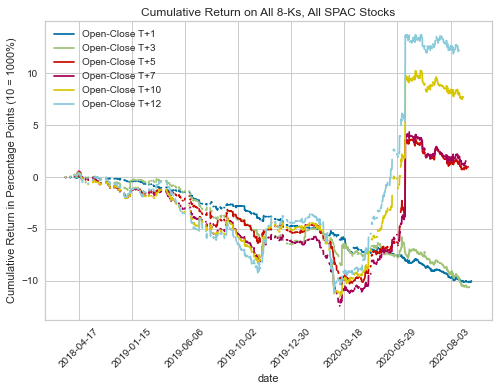

In [56]:
df_returns_all = df_returns_past.append(df_returns_current)
df_returns_all.sort_values(by='date', inplace=True)
df_returns_all.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
df_returns_all.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
df_returns_all.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
df_returns_all.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
df_returns_all.set_index('date')['open_close_t+10_%chg'].cumsum().plot(label='Open-Close T+10')
df_returns_all.set_index('date')['open_close_t+12_%chg'].cumsum().plot(label='Open-Close T+12')
plt.title('Cumulative Return on All 8-Ks, All SPAC Stocks');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

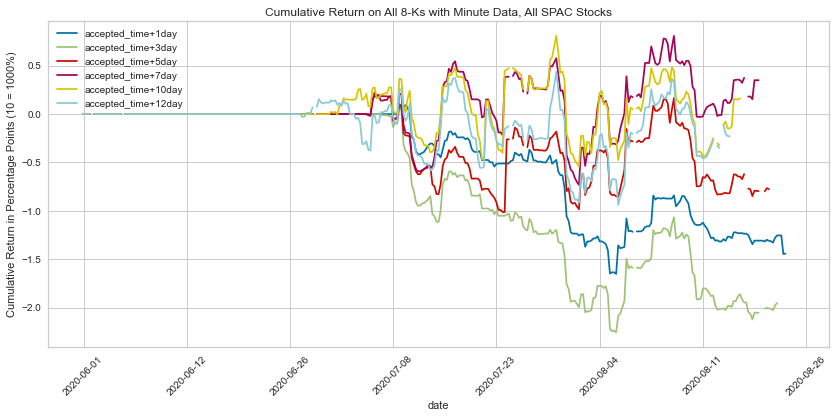

In [58]:
df_returns_all_stocks_minute.sort_values(by='accepted_time', inplace=True)
plt.figure(figsize=(14,6));
# df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+1hr_%chg'].cumsum().plot(label='accepted_time+1hr')
# df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+3hr_%chg'].cumsum().plot(label='accepted_time+3hr')
# df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+5hr_%chg'].cumsum().plot(label='accepted_time+5hr')
# df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+7hr_%chg'].cumsum().plot(label='accepted_time+7hr')
# df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+10hr_%chg'].cumsum().plot(label='accepted_time+10hr')
# df_returns_all_stocks_minute.set_index('accepted_time')['accepted_time_t+12hr_%chg'].cumsum().plot(label='accepted_time+12hr')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+1_%chg'].cumsum().plot(label='accepted_time+1day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+3_%chg'].cumsum().plot(label='accepted_time+3day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+5_%chg'].cumsum().plot(label='accepted_time+5day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+7_%chg'].cumsum().plot(label='accepted_time+7day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+10_%chg'].cumsum().plot(label='accepted_time+10day')
df_returns_all_stocks_minute.set_index('date')['accepted_time_t+12_%chg'].cumsum().plot(label='accepted_time+12day')
plt.title('Cumulative Return on All 8-Ks with Minute Data, All SPAC Stocks');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

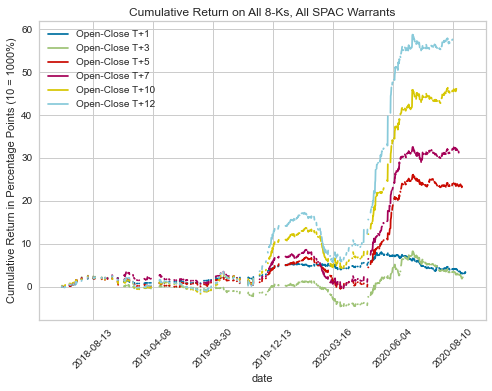

In [83]:
df_returns_all_warrants = df_returns_past_warrants_newticker.append(df_returns_current_warrants)
df_returns_all_warrants = df_returns_all_warrants.replace([np.inf, -np.inf], np.nan)
df_returns_all_warrants.sort_values(by='date', inplace=True)
df_returns_all_warrants.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
df_returns_all_warrants.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
df_returns_all_warrants.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
df_returns_all_warrants.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
df_returns_all_warrants.set_index('date')['open_close_t+10_%chg'].cumsum().plot(label='Open-Close T+10')
df_returns_all_warrants.set_index('date')['open_close_t+12_%chg'].cumsum().plot(label='Open-Close T+12')
plt.title('Cumulative Return on All 8-Ks, All SPAC Warrants');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

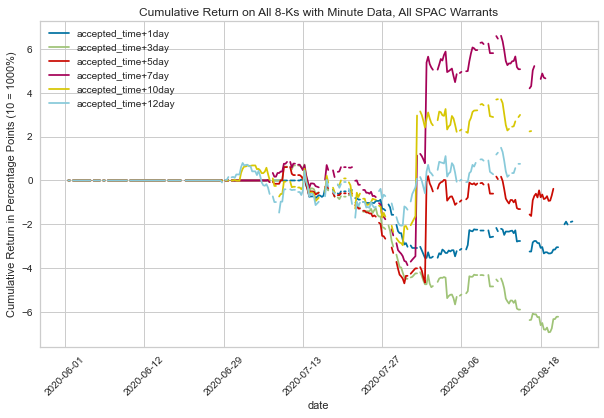

In [86]:
df_returns_all_warrants_minute.sort_values(by='accepted_time', inplace=True)
plt.figure(figsize=(10,6));
# df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+1hr_%chg'].cumsum().plot(label='accepted_time+1hr')
# df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+3hr_%chg'].cumsum().plot(label='accepted_time+3hr')
# df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+5hr_%chg'].cumsum().plot(label='accepted_time+5hr')
# df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+7hr_%chg'].cumsum().plot(label='accepted_time+7hr')
# df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+10hr_%chg'].cumsum().plot(label='accepted_time+10hr')
# df_returns_all_warrants_minute.set_index('accepted_time')['accepted_time_t+12hr_%chg'].cumsum().plot(label='accepted_time+12hr')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+1_%chg'].cumsum().plot(label='accepted_time+1day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+3_%chg'].cumsum().plot(label='accepted_time+3day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+5_%chg'].cumsum().plot(label='accepted_time+5day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+7_%chg'].cumsum().plot(label='accepted_time+7day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+10_%chg'].cumsum().plot(label='accepted_time+10day')
df_returns_all_warrants_minute.set_index('date')['accepted_time_t+12_%chg'].cumsum().plot(label='accepted_time+12day')
plt.title('Cumulative Return on All 8-Ks with Minute Data, All SPAC Warrants');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();

# Predict warrants return using 8-K content

In [88]:
def remove_header_footer(text):
    # remove/replace some unicode characters
    text = text.replace('\t','')
    text = text.replace('\x93','"')
    text = text.replace('\x94','"')
    text = text.replace('”', '"') # weird unicode/ascii conversion issue
    text = text.replace('“', '"') # weird unicode/ascii conversion issue
    
    # remove everything in header and footer
    ind_start = text.find('financial accounting standards provided pursuant to section 13(a) of the exchange act')
    ind_end = text.find('signature pursuant to the requirements of the securities exchange act of 1934')
    text = text[ind_start:ind_end]
    
    # remove forward looking statement section
    FLS_START = [
    'forward-looking statements this current report',
    'forward looking statements certain statements',
    'forward-looking statements this report',
    'forward-looking statements the company makes',
    'forward-looking statements certain of the matters',
    'forward-looking statements this communication',
    'forward-looking statements this document'
    ]
    FLS_END = [
    'undue reliance should not be placed upon the forward-looking statements',
    'whether as a result of new information, future events or otherwise, except as required by law',
    'conditions or circumstances on which any such statement is based, except as required by applicable law',
    'whether as a result of new information, future events, or otherwise'
    ]
    for forward_start in FLS_START:
        for forward_end in FLS_END:
            ind_start = text.find(forward_start)
            ind_end = text.find(forward_end)
            if ind_start!=-1 and ind_end!=-1:
                text = text[0:ind_start] + text[ind_end+len(forward_end):]
    
    # additional text to remove
    text_to_remove = [
        'financial accounting standards provided pursuant to section 13(a) of the exchange act'
    ]
    for rm in text_to_remove:
        text = text.replace(rm,'')
    
    return text

def get_item_subheaders(text, subheaders_only):
    subheaders = re.findall('item [0-9]+\.[0-9]+', text)
    subheaders = list(collections.OrderedDict.fromkeys(subheaders)) # handle cases where subheader mentioned in content
    subtexts = []
    for i in range(0,len(subheaders)):
        if i+1==len(subheaders):
            subtext = text[text.find(subheaders[i]):]
        else:
            subtext = text[text.find(subheaders[i]):text.find(subheaders[i+1])]
        if 'item 9.01 financial statements and exhibits' in subtext:
            continue
        else:
            subtexts.append(subtext)
    
    # drop these items
    drop_item_list = ['item 9.01']
    
    if subheaders_only:
        return [x for x in subheaders if x not in drop_item_list]
    return subtexts

def count_keywords(x, keywords):
    count = 0
    for keyword in keywords:
        count = count + x.count(keyword)
    return count

def text_processing(text, item_features, stemming=True):
    subtexts = get_item_subheaders(text, subheaders_only=False)
    tokens = []
    for subtext in subtexts:
        # remove item subheaders. todo: probably should remove text of subheader too
        for item in item_features:
            subtext = subtext.replace(item,'')

        # tokenize, only keeping alphanumeric
        subtokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(subtext)

        # remove stop words
        stop_words = set(nltk.corpus.stopwords.words('english'))
        subtokens = [w for w in subtokens if not w in stop_words]

        # remove numbers and chinese/other non-english characters for now
        # (todo: revisit later for vote count processing)
        subtokens = [w for w in subtokens if w.encode('utf-8').isalpha()]

        # stemming
        if stemming:
            stems = [nltk.stem.porter.PorterStemmer().stem(w) for w in subtokens]
            tokens.extend(stems)
        else:
            tokens.extend(subtokens)

    processed_text = ' '.join(tokens)
    return processed_text

def add_subheader_item_features(df_ret, item_features):
    # item definitions: https://www.sec.gov/fast-answers/answersform8khtm.html
    # item faq: https://media2.mofo.com/documents/faq-form-8-k.pdf
    for col in item_features:
        df_ret[col] = 0
    for i in range(0, len(df_ret)):
        text = df_ret.loc[i]['text']
        items = get_item_subheaders(text, subheaders_only=True)
        for item in items:
            df_ret.loc[i,item] = 1
    return df_ret

def add_bagofwords_features(df_ret, vectorizer_type, response_variable):
    # process text and create bigram, trigram features
    corpus = []
    for text in df_ret['text']:
        corpus.append(text_processing(text))
    print('vectorizer:', vectorizer_type, '\n')
    if vectorizer_type=='CountVectorizer':
        vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 3)) # Total Frequency
    elif vectorizer_type=='TfidfVectorizer':
        vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 3)) # TF-IDF
    else:
        print('vectorizer_type d.n.e')
    X_corpus = vectorizer.fit_transform(corpus)
    df_bagofwords = pd.DataFrame(X_corpus.toarray())
    df_bagofwords.columns = vectorizer.get_feature_names()
    
    # concatenate
    df_ret = pd.concat([df_ret, df_bagofwords], axis=1)

    # example features
    print('letter intent features:', [x for x in df_bagofwords.columns if 'letter intent' in x])

    # histogram
    (n, bins, patches) = plt.hist(df_ret[response_variable], bins=10, label=response_variable)
    plt.title('Histogram of ' + response_variable)
    plt.show()
    print('bins', np.round(bins,2))
    print('counts', n)
    
    return df_ret

def convert_vote_count_to_int(x):
    if '—' in x or '-' in x or 'n/a' in x:
        return 0
    try:
        x = int(x.replace(',',''))
    except:
        return np.nan
    return x

# does not handle: https://www.sec.gov/Archives/edgar/data/1704760/000161577419006723/s117785_8k.htm (no broker non-votes)
def parse_vote_results(x):
    # find strings in text. use first if multiple matches
    VOTE_HEADER = [
        'for against abstain broker non-votes',
        'for against abstain broker non-vote',
        'for against abstention broker non-votes',
        'for against abstention broker non-vote',
        'for against abstentions broker non-votes',
        'for against abstentions broker non-vote'
    ]
    # find phrases preceding vote results in text
    vote_strings = [vote_string for vote_string in VOTE_HEADER if vote_string in x['text']]

    # parse votes for, votes against, votes abstain, votes broker non votes
    if len(vote_strings)==0:
        return pd.Series([np.nan, np.nan, np.nan, np.nan])
    else:
        vote_string = vote_strings[0] # use first if multiple matches
        vote_index = x['text'].find(vote_string)
        vote_data = x['text'][(vote_index + len(vote_string)):].lstrip().split(' ')
        votes_for = convert_vote_count_to_int(vote_data[0])
        votes_against = convert_vote_count_to_int(vote_data[1])
        votes_abstain = convert_vote_count_to_int(vote_data[2])
        votes_broker_non_votes = convert_vote_count_to_int(vote_data[3])
        if np.isnan(votes_for) or np.isnan(votes_against) or np.isnan(votes_abstain) or np.isnan(votes_broker_non_votes):
            print('something wrong with parse_vote_results for', x.symbol, 'on', x.date)
        return pd.Series([votes_for, votes_against, votes_abstain, votes_broker_non_votes])
    return pd.Series([np.nan, np.nan, np.nan, np.nan])

def parse_redemptions(x):
    string_redemption_1 = 'in connection with the extension'
    string_redemption_2 = 'in connection with the closing'
    string_redemption_3 = 'in advance of the special meeting'
    string_redemption_4 = 'in connection with the special meeting'
    redemption_sentence = [sentence for sentence in x.text.split('.') if
                           string_redemption_1 in sentence
                           and ('redeem' in sentence or 'redemp' in sentence)]
    if len(redemption_sentence)==0:
        redemption_sentence = [sentence for sentence in x.text.split('.') if
                               string_redemption_2 in sentence
                               and ('redeem' in sentence or 'redemp' in sentence)]
    if len(redemption_sentence)==0:
        redemption_sentence = [sentence for sentence in x.text.split('.') if
                               string_redemption_3 in sentence
                               and ('redeem' in sentence or 'redemp' in sentence)]
    if len(redemption_sentence)==0:
        redemption_sentence = [sentence for sentence in x.text.split('.') if
                               string_redemption_4 in sentence
                               and ('redeem' in sentence or 'redemp' in sentence)]
    if len(redemption_sentence)==0:
        return np.nan
    redemption_sentence = redemption_sentence[0].lstrip().replace(',','')
    redemption_sentence = re.sub(r'[\$]{1}[\d,]+\.?\d{0,2}', '', redemption_sentence) # replace $_#_
    shares_regex_strong = re.findall('[0-9]+ shares', redemption_sentence)
    shares_regex_weak = re.findall('[0-9]+', redemption_sentence)
    # case: just one number in sentence. assume this number is redemption number
    if len(shares_regex_weak)==1:
        shares = int(shares_regex_weak[0])
    # case: more than one number in sentence. if '[0-9]+ shares' then assume this is redemption number, otherwise nan
    elif len(shares_regex_weak)>1:
        if len(shares_regex_strong)==1:
            shares = int(shares_regex_strong[0].replace('shares','').replace(' ',''))
        else:
            shares = np.nan
    # case: no numbers in sentence.
    else:
        if 'none' in redemption_sentence:
            shares = 0
        else:
            shares = np.nan
    return shares

def compute_self_engineered_feature_metrics(df_ret, col_name, response_variable):
    print('count', col_name, '> 0:', np.sum(df_ret[col_name]>0),
          '; count', response_variable, '> 0:', len(df_ret[df_ret[col_name]>0][df_ret[response_variable]>0]),
          '; count unique symbols:', len(df_ret[df_ret[col_name]>0]['symbol'].unique()))

def add_self_engineered_features(df_ret, response_variable=None):    
    # keywords lists
    keywords_list_loi = [
    'entry into a letter of intent',
    'entry into a non-binding letter of intent',
    'enter into a letter of intent',
    'enter into a non-binding letter of intent',
    'entered into a letter of intent',
    'entered into a non-binding letter of intent',
    'entering into a letter of intent',
    'entering into a non-binding letter of intent',
    'execution of a letter of intent',
    'execution of a non-binding letter of intent',
    'execute a letter of intent',
    'execute a non-binding letter of intent',
    'executed a letter of intent',
    'executed a non-binding letter of intent',
    'executing a letter of intent',
    'executing a non-binding letter of intent'
    ]
    keywords_list_business_combination_agreement = [
    '("business combination agreement")',
    '(the "business combination agreement")',
    '("business combination")',
    '(the "business combination")',
    'entry into a definitive agreement',
    'enter into a definitive agreement',
    'entered into a definitive agreement',
    'entering into a definitive agreement'
    ]
    keywords_list_merger_agreement = ['(the "merger agreement")']
    keywords_list_purchase_agreement = ['(the "purchase agreement")']
    keywords_list_extension = [
    '(the "extension")',
    '(the "extension amendment")',
    'extended the termination date'
    ]
    keywords_list_meeting = ['("special meeting")', '(the "meeting")']
    keywords_list_record = ['(the "record date")']
    keywords_list_consummation = [
    'announcing the consummation',
    'consummated the previously announced business combination'
    ]
    keywords_list_ipo = [
    'consummated its initial public offering ("ipo")',
    'consummated its initial public offering (the "ipo")',
    'consummated an initial public offering ("ipo")',
    'consummated an initial public offering (the "ipo")',
    'consummated the initial public offering ("ipo")',
    'consummated the initial public offering (the "ipo")',
    'completed its initial public offering ("ipo")',
    'completed its initial public offering (the "ipo")',
    'in connection with its initial public offering ("ipo") was declared effective',
    'in connection with its initial public offering (the "ipo") was declared effective',
    'consummated the ipo'
    ]
    keywords_list_trust = [
    'trust account'
    ]
    
    # keywords counts
    df_ret['keywords_loi'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_loi))
    df_ret['keywords_business_combination_agreement'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_business_combination_agreement))
    df_ret['keywords_merger_agreement'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_merger_agreement))
    df_ret['keywords_purchase_agreement'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_purchase_agreement))
    df_ret['keywords_extension'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_extension))
    df_ret['keywords_meeting'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_meeting))
    df_ret['keywords_record'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_record))
    df_ret['keywords_consummation'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_consummation))
    df_ret['keywords_ipo'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_ipo))
    df_ret['keywords_trust'] = df_ret.text.apply(lambda x: count_keywords(x, keywords_list_trust))
    
    # compute metrics
    if response_variable is not None:
        keywords_name_list = ['keywords_loi','keywords_business_combination_agreement','keywords_merger_agreement',
                              'keywords_purchase_agreement','keywords_extension','keywords_meeting','keywords_record',
                              'keywords_consummation','keywords_ipo','keywords_trust','item 5.07','item 3.01','item 2.03']
        for keywords_name in keywords_name_list:
            compute_self_engineered_feature_metrics(df_ret, keywords_name, response_variable)

    # vote results
    df_ret['votes_for'] = np.nan
    df_ret['votes_against'] = np.nan
    df_ret['votes_abstain'] = np.nan
    df_ret['votes_broker_non_votes'] = np.nan
    df_ret[['votes_for', 'votes_against', 'votes_abstain', 'votes_broker_non_votes']] = df_ret.apply(lambda x: parse_vote_results(x), axis=1)
    df_ret['vote_total'] = df_ret['votes_for'] + df_ret['votes_against'] + df_ret['votes_abstain'] + df_ret['votes_broker_non_votes']
    df_ret['%votes_for'] = df_ret['votes_for'] / df_ret['vote_total']
    df_ret['%vote_against'] = df_ret['votes_against'] / df_ret['vote_total']
    df_ret['%votes_abstain'] = df_ret['votes_abstain'] / df_ret['vote_total']
    df_ret['%votes_broker_non_votes'] = df_ret['votes_broker_non_votes'] / df_ret['vote_total']
    
    # shares redeemed
    df_ret['redeemed_shares'] = df_ret.apply(lambda x: parse_redemptions(x), axis=1)
    df_ret['%redeemed'] = df_ret['redeemed_shares'] / df_ret['vote_total']
    
    return df_ret

# Useful text:
# "Item 7.01 Regulation FD Disclosure": LOI, Business Combination Agreement, Business Combination consummation
# "Item 5.07 Submission of Matters to a Vote of Security Holders": vote extension, vote result
# key words LOI: definitive agreement, letter of intent
# key words business combination agreement: "business combination agreement", "business combination", "merger agreement", "purchase agreement"
# key words vote: ("special meeting"), (the "meeting"), (the "extension"), (the "extension amendment"), (the "record date")
# key words other: (the "closing date")

# Not useful:
# dropped "item 9.01 financial statements and exhibits"
# maybe drop "Forward-Looking Statements", "No Offer or Solicitation"
# maybe drop "Item 5.02. Departure of Directors or Certain Officers; Election of Directors; Appointment of Certain Officers; Compensatory Arrangements of Certain Officers."

# other notes:
# 8-Ks aren't actually iid, maybe symbols with previous positive reactions are more likely to positive
#    - example of bad reaction KXIN Form 25 https://www.sec.gov/Archives/edgar/data/1713539/000135445719000234/0001354457-19-000234-index.htm
#    - another example: NSCO Form 25 https://www.sec.gov/Archives/edgar/data/1709682/000087666119000802/0000876661-19-000802-index.htm
# stratify by sector
# add class weight instead of cv with f1 score
# maybe create set of features using all legal terms in (), e.g. (the "special meeting")

In [89]:
# data processing inputs
y_variable = 'open_close_t+5_%chg' # t+1, t+2,..., or t+12

# get all warrants and drop nan and corrupt symbols
# todo: merge newticker and oldticker df_returns_past_warrants properly. use newticker for now
df_returns_warrants = df_returns_past_warrants_newticker.append(df_returns_current_warrants)
df_returns_warrants.drop(columns=['letter_of_intent_found',
                                  'business_combination_agreement_found',
                                  'form'], inplace=True)

print('count 8-Ks:', len(df_returns_warrants))
df_returns_warrants.dropna(inplace=True)
print('count 8-Ks after dropping nan prices:', len(df_returns_warrants))
# remove corrupt symbols
df_returns_warrants = df_returns_warrants[~df_returns_warrants.symbol.isin(['ACELW','LAZYW'])]
print('count 8-Ks after dropping corrupt symbols:', len(df_returns_warrants), '\n')
df_returns_warrants.sort_values(by='accepted_time', inplace=True) # need to sort for TimeSeriesSplit
df_returns_warrants.reset_index(inplace=True, drop=True)

print('predicting:', y_variable)

# define item features
item_features = ['item 1.01','item 1.02','item 1.03','item 1.04','item 2.01','item 2.02','item 2.03','item 2.04',
                 'item 2.05','item 2.06','item 3.01','item 3.02','item 3.03','item 4.01','item 4.02','item 5.01',
                 'item 5.02','item 5.03','item 5.04','item 5.05','item 5.06','item 5.07','item 5.08','item 6.01',
                 'item 6.02','item 6.03','item 6.04','item 6.05','item 7.01','item 8.01']

# remove header and footer
df_returns_warrants['text'] = df_returns_warrants.text.apply(lambda x: remove_header_footer(x))

# add subheader item binary features
df_returns_warrants = add_subheader_item_features(df_ret=df_returns_warrants, item_features=item_features)

# add bag of words features
# df_returns_warrants = add_bagofwords_features(df_ret=df_returns_warrants,
#                                               vectorizer_type='CountVectorizer', # CountVectorizer or TfidfVectorizer
#                                               response_variable=y_variable)

# add self engineered features
df_returns_warrants = add_self_engineered_features(df_ret=df_returns_warrants, response_variable=y_variable)

count 8-Ks: 1807
count 8-Ks after dropping nan prices: 759
count 8-Ks after dropping corrupt symbols: 733 

predicting: open_close_t+5_%chg
count keywords_loi > 0: 13 ; count open_close_t+5_%chg > 0: 6 ; count unique symbols: 11
count keywords_business_combination_agreement > 0: 117 ; count open_close_t+5_%chg > 0: 55 ; count unique symbols: 41
count keywords_merger_agreement > 0: 39 ; count open_close_t+5_%chg > 0: 15 ; count unique symbols: 22
count keywords_purchase_agreement > 0: 25 ; count open_close_t+5_%chg > 0: 9 ; count unique symbols: 10
count keywords_extension > 0: 47 ; count open_close_t+5_%chg > 0: 26 ; count unique symbols: 21
count keywords_meeting > 0: 30 ; count open_close_t+5_%chg > 0: 13 ; count unique symbols: 16
count keywords_record > 0: 5 ; count open_close_t+5_%chg > 0: 1 ; count unique symbols: 5
count keywords_consummation > 0: 15 ; count open_close_t+5_%chg > 0: 8 ; count unique symbols: 11
count keywords_ipo > 0: 4 ; count open_close_t+5_%chg > 0: 1 ; count

strings match: ['entry into a letter of intent', 'entry into a non-binding letter of intent', 'entered into a letter of intent', 'entered into a non-binding letter of intent', 'entering into a letter of intent', 'entering into a non-binding letter of intent', 'execute a letter of intent', 'execute a non-binding letter of intent', 'executed a letter of intent', 'executed a non-binding letter of intent', 'executing a letter of intent', 'executing a non-binding letter of intent', 'execution of a letter of intent', 'execution of a non-binding letter of intent'] 

count 8-Ks matched: 12


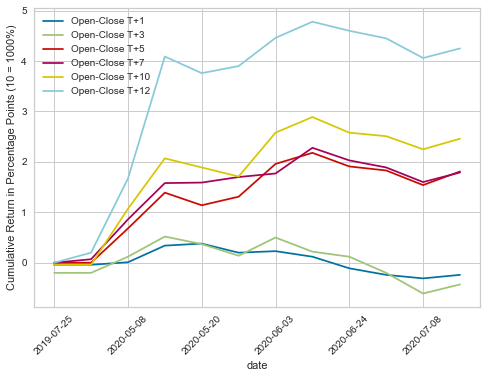

strings match: ['("business combination agreement")', '(the "business combination agreement")', '("business combination")', '(the "business combination")', 'entry into a definitive agreement', 'enter into a definitive agreement', 'entered into a definitive agreement', 'entering into a definitive agreement', 'business combination proposal was approved'] 

count 8-Ks matched: 139


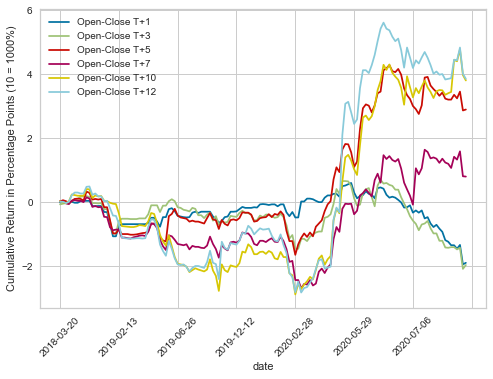

strings match: ['(the "extension")', '(the "extension amendment")', 'extended the termination date'] 

count 8-Ks matched: 41


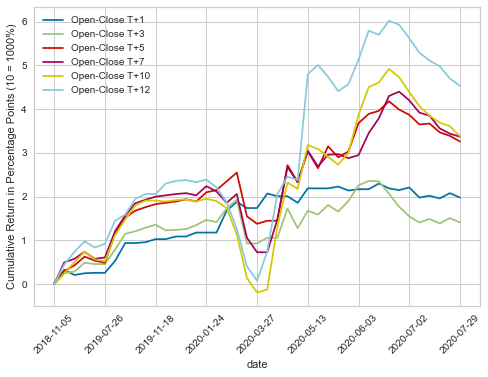

strings match: ['announcing the consummation', 'consummated the previously announced business combination', 'consummated the remainder of the transactions contemplated by the business combination', 'consummation of the transactions'] 

count 8-Ks matched: 62


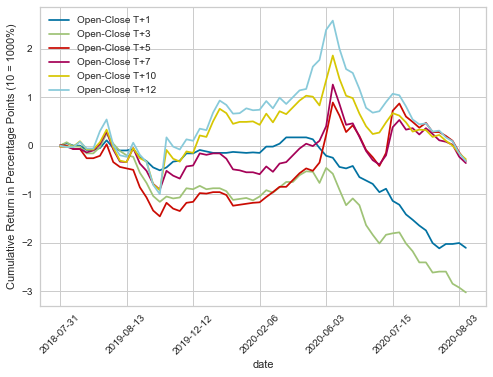

strings match: ['form of presentation', 'furnished an investor presentation', 'updated investor presentation', 'investor presentation are furnished', 'form of investor presentation', 'update the investor presentation'] 

count 8-Ks matched: 28


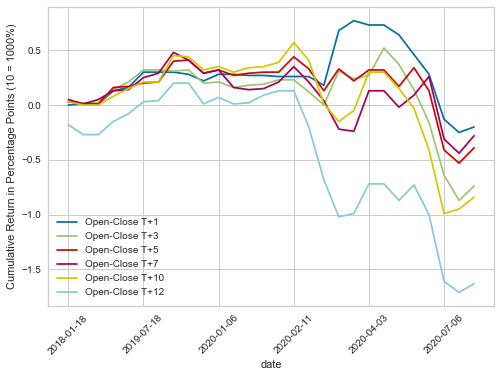

strings match: ['investor presentation'] 

count 8-Ks matched: 113


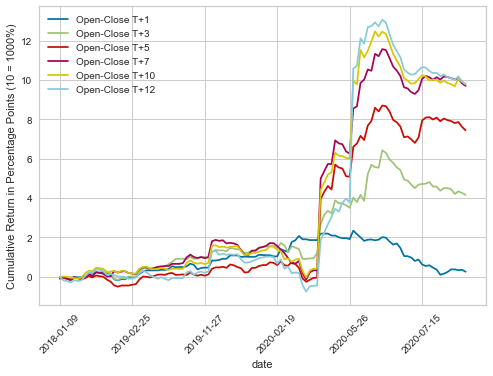

strings match: ['(the "trust account")', '(the "contribution")', '(the "revised contribution")'] 

count 8-Ks matched: 16


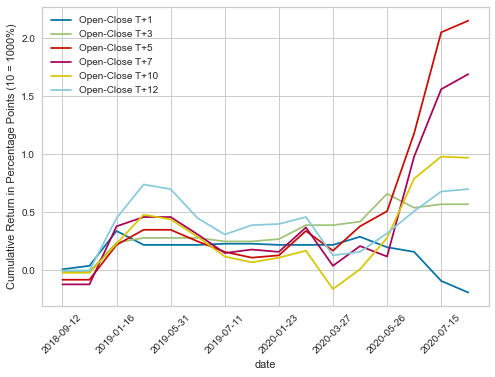

strings match: ['trust account'] 

count 8-Ks matched: 105


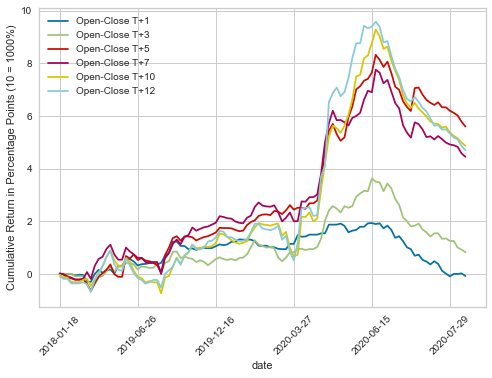

strings match: ['form 25'] 

count 8-Ks matched: 4


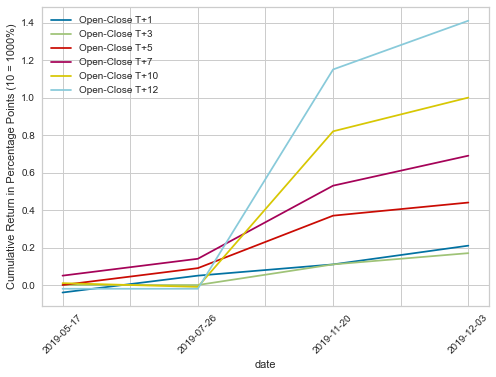

strings match: ['consummated its initial public offering ("ipo")', 'consummated its initial public offering (the "ipo")', 'consummated an initial public offering ("ipo")', 'consummated an initial public offering (the "ipo")', 'consummated the initial public offering ("ipo")', 'consummated the initial public offering (the "ipo")', 'completed its initial public offering ("ipo")', 'completed its initial public offering (the "ipo")', 'in connection with its initial public offering ("ipo") was declared effective', 'in connection with its initial public offering (the "ipo") was declared effective', 'consummated the ipo'] 

count 8-Ks matched: 0


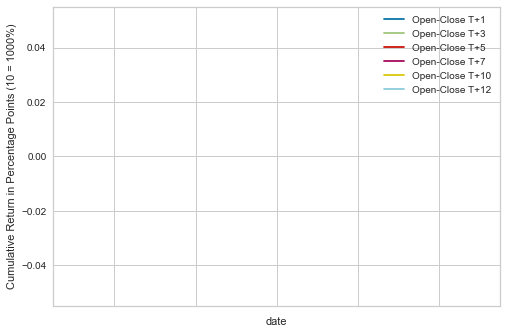

strings match: ['pipe'] 

count 8-Ks matched: 33


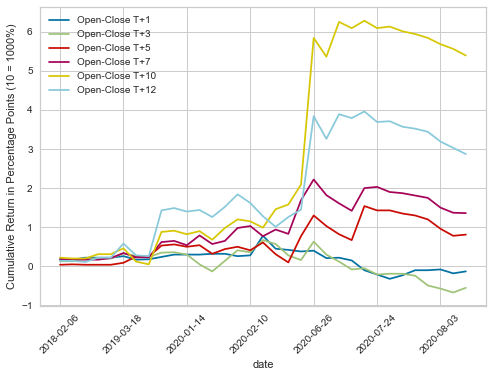

In [91]:
# study different keywords

def string_match_test(test_strings):
    print('strings match:', test_strings, '\n')
    df_matched = df_returns_warrants[(df_returns_warrants.text.str.contains('|'.join(test_strings))) &
                                     (df_returns_warrants['item 2.03']==0)]
    print('count 8-Ks matched:', len(df_matched))
    df_matched.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
    df_matched.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
    df_matched.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
    df_matched.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
    df_matched.set_index('date')['open_close_t+10_%chg'].cumsum().plot(label='Open-Close T+10')
    df_matched.set_index('date')['open_close_t+12_%chg'].cumsum().plot(label='Open-Close T+12')
    plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
    plt.xticks(rotation=45);
    plt.legend();
    plt.show();

# loi
string_match_test(test_strings=[
    'entry into a letter of intent',
    'entry into a non-binding letter of intent',
    'entered into a letter of intent',
    'entered into a non-binding letter of intent',
    'entering into a letter of intent',
    'entering into a non-binding letter of intent',
    'execute a letter of intent',
    'execute a non-binding letter of intent',
    'executed a letter of intent',
    'executed a non-binding letter of intent',
    'executing a letter of intent',
    'executing a non-binding letter of intent',
    'execution of a letter of intent',
    'execution of a non-binding letter of intent',
])
    
# bca
string_match_test(test_strings=[
    '("business combination agreement")',
    '(the "business combination agreement")',
    '("business combination")',
    '(the "business combination")',
    'entry into a definitive agreement',
    'enter into a definitive agreement',
    'entered into a definitive agreement',
    'entering into a definitive agreement',
    'business combination proposal was approved',
#     'entered into a stock and unit purchase agreement',
#     'entered into a securities purchase agreement',
#     'entered into an agreement and plan of merger',
#     'entered into a share exchange agreement',
])

# extension
string_match_test(test_strings=[
    '(the "extension")',
    '(the "extension amendment")',
    'extended the termination date',
])

# consummation
string_match_test(test_strings=[
    'announcing the consummation',
    'consummated the previously announced business combination',
    'consummated the remainder of the transactions contemplated by the business combination',
    'consummation of the transactions',
])
                  
# investor presentation
string_match_test(test_strings=[
    'form of presentation',
    'furnished an investor presentation',
    'updated investor presentation',
    'investor presentation are furnished',
    'form of investor presentation',
    'update the investor presentation',
])
string_match_test(test_strings=[ # this could be a good one
    'investor presentation'
])

# trust account
string_match_test(test_strings=[
    '(the "trust account")',
    '(the "contribution")',
    '(the "revised contribution")',
])
string_match_test(test_strings=[ # this could be a good one
    'trust account',
])

# form 25-nse
string_match_test(test_strings=[ # expect this to be a sell signal
    'form 25',
])

# consummate IPO
string_match_test(test_strings=[
    'consummated its initial public offering ("ipo")',
    'consummated its initial public offering (the "ipo")',
    'consummated an initial public offering ("ipo")',
    'consummated an initial public offering (the "ipo")',
    'consummated the initial public offering ("ipo")',
    'consummated the initial public offering (the "ipo")',
    'completed its initial public offering ("ipo")',
    'completed its initial public offering (the "ipo")',
    'in connection with its initial public offering ("ipo") was declared effective',
    'in connection with its initial public offering (the "ipo") was declared effective',
    'consummated the ipo',
])

# pipe investor
string_match_test(test_strings=[
    'pipe',
])

In [ ]:
# randomly sample 8-Ks for populating test cases
# path_saved_8K = 'data/sec_filings_df'
# files_8Ks = [f for f in os.listdir(path_saved_8K) if os.path.isfile(os.path.join(path_saved_8K, f))]
# df_8Ks = pd.DataFrame()
# for file in files_8Ks:
#     df_8K = pd.read_csv(path_saved_8K+'/'+file)
#     df_8K['symbol'] = file.split('_')[0]
#     df_8Ks = df_8Ks.append(df_8K)
# df_8Ks.drop_duplicates(subset=['date','accepted_time','text'], inplace=True)
# df_8Ks.reset_index(drop=True, inplace=True)
# R = np.random.RandomState(123)
# random_inds = R.random_integers(0, len(df_8Ks), 110)
# df_8Ks[df_8Ks.index.isin(random_inds[100:110])]

# check single test case
# spac_list_temp = process_current_spacs(file_path_current='data/spac_list_temp.csv', write=False)
# temp = get_forms_text(company_name=spac_list_temp.title[0], cik_id=spac_list_temp.cik[0], form_type='8-K')
# temp['symbol'] = spac_list_temp.ticker[0]
# temp['text'] = temp.text.apply(lambda x: remove_header_footer(x))
# temp = add_subheader_item_features(df_ret=temp, item_features=item_features)
# temp = add_self_engineered_features(df_ret=temp)
# display(temp.head(1))

#### Binary Classification

In [92]:
def apply_lsa_dim_reduction(X, n_lsa):
    lsa = TruncatedSVD(n_components=n_lsa, n_iter=10, random_state=123)
    X = pd.DataFrame(lsa.fit_transform(X), columns=['lsa'+str(i) for i in range(0,n_lsa)])
    print('count feature after LSA:', len(X.columns), '\n')
    return X

def binary_classification_eval_metrics(y_actual, y_pred):
    print('% predicted positive labels:', np.round(sum(y_pred)/len(y_pred), 2))
    print('% actual positive labels:', np.round(sum(y_actual)/len(y_actual), 2))
    cm = confusion_matrix(y_actual, y_pred)
    print('confusion matrix:\n', cm)
    print(classification_report(y_actual, y_pred, target_names=['0','1']))

def binary_classification_report(model, X_train, X_test, y_train, y_test, feature_importance=True):
    print('############\nTraining set\n############')
    y_train_pred = model.predict(X_train)
    binary_classification_eval_metrics(y_train, y_train_pred)
    metrics.plot_roc_curve(model, X_train, y_train);
    plt.title('ROC curve (train)')
    plt.show()
    metrics.plot_precision_recall_curve(model, X_train, y_train)
    plt.title('Precision-recall curve (train)');
    plt.show()
    
    print('#########\nTest set\n#########')
    y_test_pred = model.predict(X_test)
    binary_classification_eval_metrics(y_test, y_test_pred)
    metrics.plot_roc_curve(model, X_test, y_test);
    plt.title('ROC curve (test)')
    plt.show()
    metrics.plot_precision_recall_curve(model, X_test, y_test)
    plt.title('Precision-recall curve (test)');
    plt.show()
    
    print('#########\nAll data\n#########')
    y_all_pred = model.predict(X)
    binary_classification_eval_metrics(y, y_all_pred)
    metrics.plot_roc_curve(model, X, y);
    plt.title('ROC curve (all)')
    plt.show()
    metrics.plot_precision_recall_curve(model, X, y)
    plt.title('Precision-recall curve (all)');
    plt.show()
    
    # feature importance
    if feature_importance:
        try:
            coefs = model.coef_[0]
        except:
            coefs = model.feature_importances_
        indices = np.argsort(np.abs(coefs))[::-1]
        count_nonzero_features = len(X.columns[coefs!=0])
        print('count nonzero features:', count_nonzero_features)
        if count_nonzero_features < 10:
            top_n_features = count_nonzero_features
        else:
            top_n_features = 10
        plt.bar(range(top_n_features), coefs[indices[:top_n_features]], align='center')
        plt.xticks(range(top_n_features), X.columns[indices[:top_n_features]], rotation=45, ha='right')
        plt.subplots_adjust(bottom=0.3)
        plt.title('Feature importance')
        plt.show()

In [99]:
# inputs
label_threshold = 0
min_word_freq = 0
n_lsa = None # None or int

# prep data
cols_drop = ['symbol','date','accepted_time','text','url','votes_for','votes_against',
             'votes_abstain','votes_broker_non_votes','vote_total','%votes_for',
             '%votes_abstain','%votes_broker_non_votes','redeemed_shares']
cols_drop.extend([col for col in df_returns_warrants.columns if '%chg' in col])
X = df_returns_warrants.drop(cols_drop, axis=1)
X[['%vote_against','%redeemed']] = X[['%vote_against','%redeemed']].fillna(0)
print('count features:', len(X.columns))
X = X[X.columns[X.sum() >= min_word_freq].tolist()] # min word frequency
print('count features > min_word_freq:', len(X.columns))
if n_lsa is not None:
    X = apply_lsa_dim_reduction(X, n_lsa) # lsa dimension reduction
y = np.where(df_returns_warrants[y_variable] > label_threshold, 1, 0) # label threshold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('training dim:', X_train.shape)
print('testing dim:', X_test.shape, '\n')
print('count 0:', np.sum(y==0))
print('count 1:', np.sum(y==1))

count features: 42
count features > min_word_freq: 42
training dim: (586, 42)
testing dim: (147, 42) 

count 0: 401
count 1: 332


Naive rule based model

############
Training set
############
% predicted positive labels: 0.15
% actual positive labels: 0.44
confusion matrix:
 [[278  49]
 [219  40]]
              precision    recall  f1-score   support

           0       0.56      0.85      0.67       327
           1       0.45      0.15      0.23       259

    accuracy                           0.54       586
   macro avg       0.50      0.50      0.45       586
weighted avg       0.51      0.54      0.48       586

#########
Test set
#########
% predicted positive labels: 0.17
% actual positive labels: 0.5
confusion matrix:
 [[65  9]
 [57 16]]
              precision    recall  f1-score   support

           0       0.53      0.88      0.66        74
           1       0.64      0.22      0.33        73

    accuracy                           0.55       147
   macro avg       0.59      0.55      0.49       147
weighted avg       0.59      0.55      0.50       147

#########
All data
#########
% predicted posi

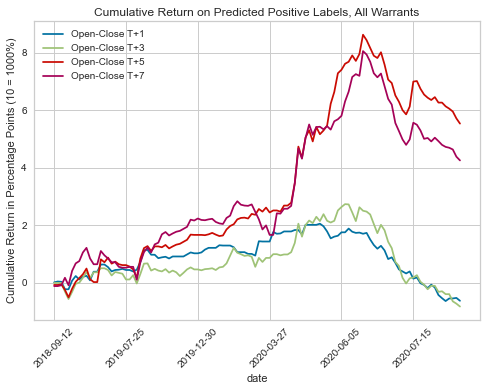

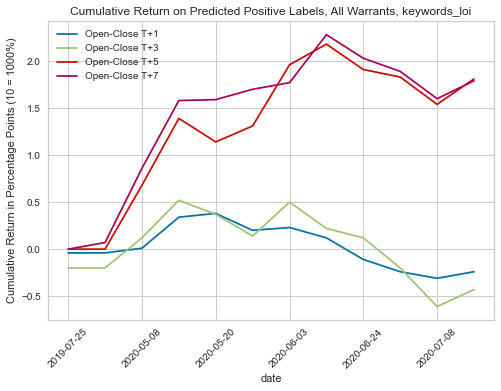

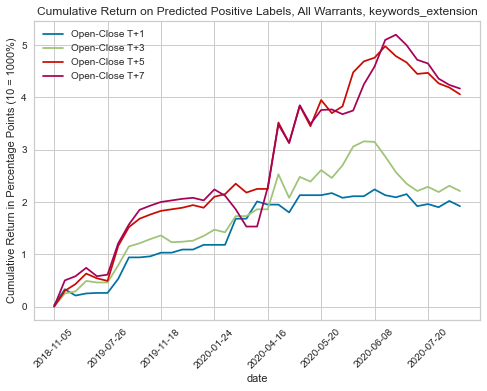

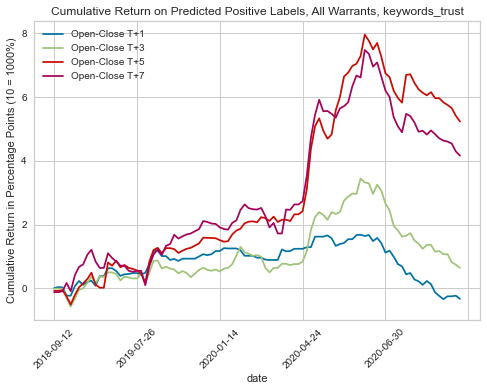

count keywords_loi > 0: 12 ; count open_close_t+5_%chg > 0: 6 ; count unique symbols: 11
count keywords_extension > 0: 39 ; count open_close_t+5_%chg > 0: 24 ; count unique symbols: 16
count keywords_trust > 0: 99 ; count open_close_t+5_%chg > 0: 48 ; count unique symbols: 46


In [100]:
print('Naive rule based model\n')

def naive_rule(x):
    if ~np.isnan(x['%vote_against']) and (x['%vote_against'] > .10):
        return 0
    elif x['keywords_ipo'] > 0:
        return 0
    else:
        if (x['keywords_loi'] > 0) and (x['item 2.03'] == 0):
            return 1
#         elif (x['keywords_business_combination_agreement'] > 0) and (x['item 2.03'] == 0):
#             return 1
#         elif (x['keywords_consummation'] > 0) and (x['item 2.03'] == 0):
#             return 1
        elif (x['keywords_extension'] > 0) and (x['item 2.03'] == 0):
            return 1
        elif (x['keywords_trust'] > 0) and (x['item 2.03'] == 0):
            return 1
        else:
            return 0

y_train_pred = X_train.apply(lambda x: naive_rule(x), axis=1)
y_test_pred = X_test.apply(lambda x: naive_rule(x), axis=1)
y_all_pred = X.apply(lambda x: naive_rule(x), axis=1)

print('############\nTraining set\n############')
binary_classification_eval_metrics(y_train, y_train_pred)

print('#########\nTest set\n#########')
binary_classification_eval_metrics(y_test, y_test_pred)

print('#########\nAll data\n#########')
binary_classification_eval_metrics(y, y_all_pred)
print('Count examples:', len(y))
print('Count positive labels:', y_all_pred.sum())
count_months = int(np.round((dt.strptime(df_returns_warrants.date.max(),'%Y-%m-%d') -
                             dt.strptime(df_returns_warrants.date.min(),'%Y-%m-%d')).days / 365. * 12, 0))
print('Count months:', count_months)
print('Trades / month:', np.round(y_all_pred.sum()/count_months, 1))

df_pred_pos = df_returns_warrants.loc[np.where(y_all_pred==1)[0],]
print(y_variable, 'sum:', np.round(df_pred_pos[y_variable].sum(), 2))
# todo: calculate sharpe and sortino ratios properly
print(y_variable, 'mean:', np.round(df_pred_pos[y_variable].mean(), 2))
print(y_variable, 'sd:', np.round(df_pred_pos[y_variable].std(), 2))
print(y_variable, 'downside sd:', np.round(df_pred_pos[y_variable][df_pred_pos[y_variable]<0].std(), 2))

df_pred_pos.set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
df_pred_pos.set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
df_pred_pos.set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
df_pred_pos.set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
plt.title('Cumulative Return on Predicted Positive Labels, All Warrants');
plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
plt.xticks(rotation=45);
plt.legend();
plt.show();

cols_plot = ['keywords_loi',
#              'keywords_business_combination_agreement',
#              'keywords_consummation',
             'keywords_extension',
             'keywords_trust']
for col in cols_plot:
    df_pred_pos[df_pred_pos[col]>0].set_index('date')['open_close_t+1_%chg'].cumsum().plot(label='Open-Close T+1')
    df_pred_pos[df_pred_pos[col]>0].set_index('date')['open_close_t+3_%chg'].cumsum().plot(label='Open-Close T+3')
    df_pred_pos[df_pred_pos[col]>0].set_index('date')['open_close_t+5_%chg'].cumsum().plot(label='Open-Close T+5')
    df_pred_pos[df_pred_pos[col]>0].set_index('date')['open_close_t+7_%chg'].cumsum().plot(label='Open-Close T+7')
    plt.title('Cumulative Return on Predicted Positive Labels, All Warrants, '+col);
    plt.ylabel('Cumulative Return in Percentage Points (10 = 1000%)');
    plt.xticks(rotation=45);
    plt.legend();
    plt.show();
    
# gini-like metric for predicted positive labels
keywords_name_list = ['keywords_loi','keywords_extension','keywords_trust']
for keywords_name in keywords_name_list:
    compute_self_engineered_feature_metrics(df_pred_pos, keywords_name, y_variable)

# todo: weird ones to look at
# GTYH: df_returns_warrants[df_returns_warrants.symbol=='GTYHW'].loc[115,'text']...somehow doesn't match up with https://www.sec.gov/Archives/edgar/data/1682325/000114420419014675/tv516340_8k12ba.htm

In [101]:
print('loi symbols:', df_returns_warrants[(df_returns_warrants.keywords_loi>0)].symbol.unique())
print('\nbusiness combination agreement symbols:', df_returns_warrants[(df_returns_warrants.keywords_business_combination_agreement>0)].symbol.unique())
print('\nextension symbols:', df_returns_warrants[(df_returns_warrants.keywords_extension>0)].symbol.unique())
print('\nconsummation symbols:', df_returns_warrants[(df_returns_warrants.keywords_consummation>0)].symbol.unique())
print('\ntrust symbols:', df_returns_warrants[(df_returns_warrants.keywords_trust>0)].symbol.unique())

loi symbols: ['PAACW' 'AVCTW' 'AMCIW' 'FMCIW' 'MFACW' 'SAMAW' 'OPESW' 'BMRGW' 'NFINW'
 'HOFVW' 'HYACW']

business combination agreement symbols: ['MGYW' 'PRTHW' 'WTRHW' 'THW' 'GTYHW' 'AVCTW' 'LHCW' 'KXINW' 'AESEW'
 'KERNW' 'ATCXW' 'ALACW' 'GTECW' 'BRMKW' 'KLRW' 'PACQW' 'NEBUW' 'HCCHW'
 'IMVTW' 'HYMCW' 'MNCLW' 'LACQW' 'GSMGW' 'NKLAW' 'PAACW' 'AMCIW' 'FMCIW'
 'MFACW' 'SAMAW' 'CCHW' 'OPESW' 'AHCOW' 'SHLLW' 'CRSAW' 'SPAQW' 'CCXXW'
 'HYACW' 'GRAFW' 'TZACW' 'NFINW' 'ARYBW']

extension symbols: ['GTYHW' 'AVCTW' 'AESEW' 'SPCEW' 'HOFVW' 'BRPAW' 'OPESW' 'PACQW' 'LACQW'
 'HCCHW' 'NEBUW' 'FMCIW' 'NKLAW' 'ALGRW' 'GRAFW' 'ALACW' 'MFACW' 'CFFAW'
 'SAMAW' 'LFACW' 'ANDAW']

consummation symbols: ['PRTHW' 'GRAFW' 'GTYHW' 'THW' 'PACKW' 'NSCOW' 'GTECW' 'AHCOW' 'BRMKW'
 'NKLAW' 'HOFVW']

trust symbols: ['THW' 'GTYHW' 'MFACW' 'GRAFW' 'AESEW' 'AVCTW' 'LHCW' 'KXINW' 'PACKW'
 'KERNW' 'SPCEW' 'RPAYW' 'PAACW' 'HOFVW' 'TOTAW' 'NSCOW' 'BRPAW' 'GSMGW'
 'OPESW' 'ALACW' 'ALGRW' 'KLRW' 'LACQW' 'MNCLW' 'NEBUW' 'HCCHW' 

In [102]:
df_pred_pos.groupby('symbol').agg({'accepted_time':'count'}).sort_values(by='accepted_time', ascending=False).head()

accepted_time
symbol               
HOFVW              12
AVCTW               8
GRAFW               6
AESEW               5
LACQW               5

In [103]:
df_pred_pos.sort_values(by='open_close_t+3_%chg').head()

date  \
647  2020-07-02   
528  2020-05-12   
656  2020-07-08   
637  2020-06-30   
414  2020-02-27   

                                                                                                    text  \
647  . ☐ item 5.07 submission of matters to a vote of security holders. on june 30, 2019, the company...   
528  . ¨ title of each class trading symbol(s) name of each exchange on which registered common stock...   
656  . ☐ introductory note on july 1, 2020, (the "closing date"), hall of fame resort & entertainment...   
637  . ☐ item 1.01entry into a material definitive agreement. amendment to investment management trus...   
414  . ☐ item 8.01 other events. as previously reported, on january 24, 2020, gordon pointe acquisiti...   

                                                                                                   url  \
647  https://www.sec.gov/Archives/edgar/data/1708176/000121390020016578/0001213900-20-016578-index.htm   
528  https://www.sec.gov/Archives/edgar/data/1731289/000110465920060165/0001104659-20-060165-index.htm   
656  https://www.sec.gov/Archives/edgar/data/1708176/000121390020016991/0001213900-20-016991-index.htm   
637  https://www.sec.gov/Archives/edgar/data/1716947/000121390020016355/0001213900-20-016355-index.htm   
414  https://www.sec.gov/Archives/edgar/data/1708176/000121390020004940/0001213900-20-004940-index.htm   

           accepted_time  open_close_t+1_%chg  open_close_t+2_%chg  \
647  2020-07-02 16:29:06                -0.19                -0.37   
528  2020-05-12 16:05:14                -0.15                -0.37   
656  2020-07-08 17:16:25                -0.07                -0.17   
637  2020-06-30 17:25:17                -0.30                -0.40   
414  2020-02-27 17:20:33                -0.06                -0.06   

     open_close_t+3_%chg  open_close_t+4_%chg  open_close_t+5_%chg  \
647                -0.48                -0.33                -0.43   
528                -0.45                -0.46                -0.39   
656                -0.41                -0.38                -0.29   
637                -0.40                -0.44                -0.52   
414                -0.35                -0.03                -0.03   

     open_close_t+6_%chg  open_close_t+7_%chg  open_close_t+8_%chg  \
647                -0.50                -0.64                -0.62   
528                -0.37                -0.35                -0.26   
656                -0.31                -0.29                -0.17   
637                -0.51                -0.44                -0.35   
414                -0.26                -0.26                -0.03   

     open_close_t+9_%chg  open_close_t+10_%chg  open_close_t+11_%chg  \
647                -0.57                 -0.58                 -0.57   
528                -0.26                 -0.14                 -0.12   
656                -0.25                 -0.26                 -0.32   
637                -0.48                 -0.39                 -0.45   
414                 0.15                  0.03                  0.06   

     open_close_t+12_%chg symbol  item 1.01  item 1.02  item 1.03  item 1.04  \
647                 -0.50  HOFVW          0          0          0          0   
528                 -0.08  NKLAW          0          0          0          0   
656                 -0.39  HOFVW          1          0          0          0   
637                 -0.50  LACQW          1          0          0          0   
414                  0.12  HOFVW          0          0          0          0   

     item 2.01  item 2.02  item 2.03  item 2.04  item 2.05  item 2.06  \
647          0          0          0          0          0          0   
528          0          0          0          0          0          0   
656          1          0          0          0          0          0   
637          0          0          0          0          0          0   
414          0          0          0          0          0          

Logistic Regression

Best 5-fold CV (TimeSeriesSplit) score: 0.492020 using {'C': 10} 



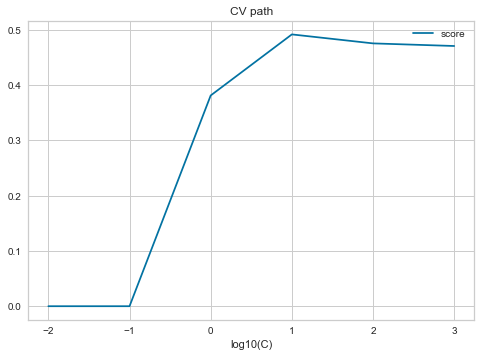

############
Training set
############
% predicted positive labels: 0.23
% actual positive labels: 0.44
confusion matrix:
 [[270  57]
 [184  75]]
              precision    recall  f1-score   support

           0       0.59      0.83      0.69       327
           1       0.57      0.29      0.38       259

    accuracy                           0.59       586
   macro avg       0.58      0.56      0.54       586
weighted avg       0.58      0.59      0.56       586



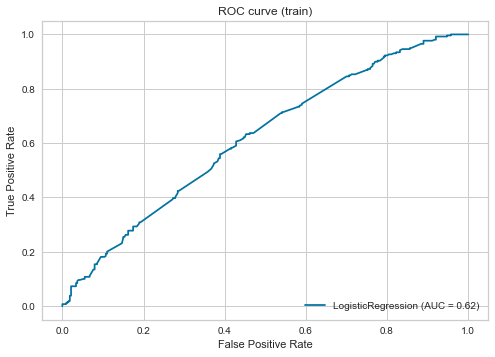

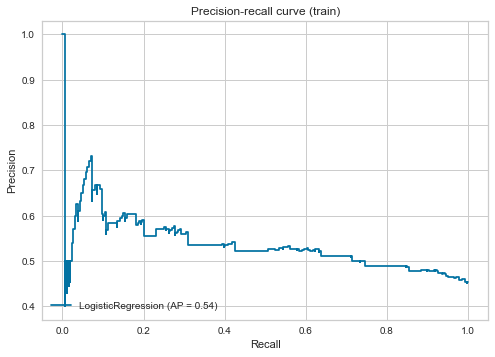

#########
Test set
#########
% predicted positive labels: 0.19
% actual positive labels: 0.5
confusion matrix:
 [[56 18]
 [63 10]]
              precision    recall  f1-score   support

           0       0.47      0.76      0.58        74
           1       0.36      0.14      0.20        73

    accuracy                           0.45       147
   macro avg       0.41      0.45      0.39       147
weighted avg       0.41      0.45      0.39       147



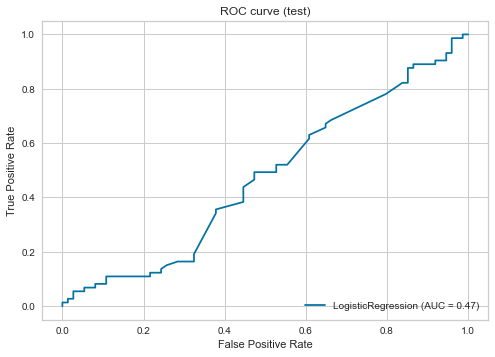

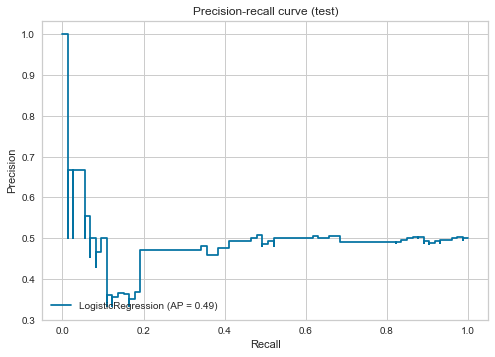

#########
All data
#########
% predicted positive labels: 0.22
% actual positive labels: 0.45
confusion matrix:
 [[326  75]
 [247  85]]
              precision    recall  f1-score   support

           0       0.57      0.81      0.67       401
           1       0.53      0.26      0.35       332

    accuracy                           0.56       733
   macro avg       0.55      0.53      0.51       733
weighted avg       0.55      0.56      0.52       733



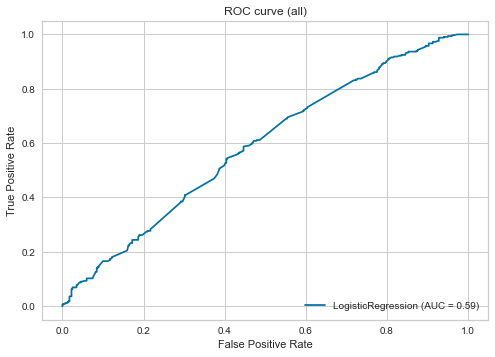

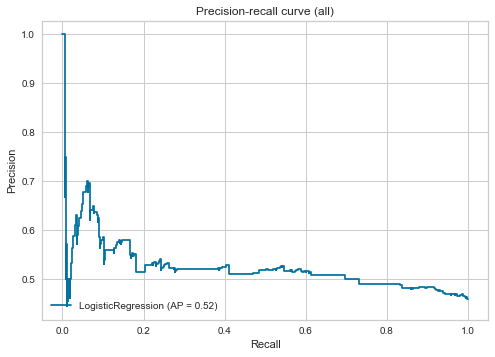

count nonzero features: 31


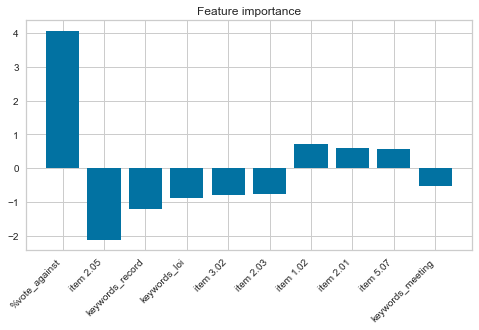

In [104]:
print('Logistic Regression\n')

# CV
model_lr = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
C = [.01, .1, 1, 10, 100, 1000]
# C = np.linspace(.5, 1.5, 10)
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_lr, param_grid, scoring='precision', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_lr = LogisticRegression(penalty='l1', solver='liblinear', C=grid_result.best_params_['C'], max_iter=1000)
model_lr.fit(X_train, y_train)
binary_classification_report(model_lr, X_train, X_test, y_train, y_test)

In [ ]:
print('Decision Tree\n')

# CV
model_dt = DecisionTreeClassifier()
max_depth = list(range(1, 5))
# min_samples_split = [.001, .01, .05, .1]
# min_samples_leaf = [.001, .01, .05, .1]
param_grid = dict(max_depth=max_depth) #, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_dt, param_grid, scoring='f1', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'max_depth': max_depth})
reg_path.plot(x='max_depth')
plt.title('CV path')
plt.xlabel('max_depth')
plt.show()

# model
model_dt = DecisionTreeClassifier(max_depth=grid_result.best_params_['max_depth'])
#                                   min_samples_split=grid_result.best_params_['min_samples_split'],
#                                   min_samples_leaf=grid_result.best_params_['min_samples_leaf'])
model_dt.fit(X_train, y_train)
binary_classification_report(model_dt, X_train, X_test, y_train, y_test)

# tree diagram
tree_data = export_graphviz(model_dt, out_file=None, feature_names=X.columns, class_names=['-1','1'],
                            filled=True, rounded=True, rotate=True, impurity=False)
graph = graphviz.Source(tree_data)
graph

In [ ]:
print('Random Forest\n')

# CV
model_rf = RandomForestClassifier()
n_estimators = list(range(1, 5))
max_depth = list(range(1, 5))
min_samples_leaf = [.01, .05, .1, .2]
max_features = [.01, .05, .1]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth,
                  min_samples_leaf=min_samples_leaf, max_features=max_features)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_rf, param_grid, scoring='f1', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')

# model
model_rf = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                  max_depth=grid_result.best_params_['max_depth'],
                                  min_samples_leaf=grid_result.best_params_['min_samples_leaf'],
                                  max_features=grid_result.best_params_['max_features'])
model_rf.fit(X_train, y_train)
binary_classification_report(model_rf, X_train, X_test, y_train, y_test)

In [ ]:
print('SVM\n')

kernel_type = 'linear' # linear, rbf, poly

# CV
model_svm = SVC(kernel=kernel_type)
C = [.01, .1, 1, 10, 100, 1000, 10000]
# C = [.6, .7, .8, .9, 1, 1.1, 1.2]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_svm, param_grid, scoring='f1', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_svm = SVC(kernel=kernel_type, C=grid_result.best_params_['C'])
model_svm.fit(X_train, y_train)
binary_classification_report(model_svm, X_train, X_test, y_train, y_test, feature_importance=False)

#### 3-Class Classification

In [ ]:
def get_multi_labels(x):
    if x < first_label_threshold:
        return -1
    elif x > second_label_threshold:
        return 1
    else:
        return 0
    
def plot_roc_multi(model_multi, X_input, y_input):
    y_binarized = preprocessing.label_binarize(y_input, classes=[-1, 0, 1])
    n_classes = y_binarized.shape[1]
    fpr = dict()
    tpr = dict()
    from itertools import cycle
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_binarized[:, i], model_multi.predict_proba(X_input)[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    
def multi_classification_eval_metrics(y_actual, y_pred):
    print('% predicted (actual) -1 labels: {} ({})'.format(np.round(sum(y_pred==-1)/len(y_pred), 2),
                                                           np.round(sum(y_actual==-1)/len(y_actual), 2)))
    print('% predicted (actual) 0 labels: {} ({})'.format(np.round(sum(y_pred==0)/len(y_pred), 2),
                                                          np.round(sum(y_actual==0)/len(y_actual), 2)))
    print('% predicted (actual) 1 labels: {} ({})'.format(np.round(sum(y_pred==1)/len(y_pred), 2),
                                                          np.round(sum(y_actual==1)/len(y_actual), 2)))
    cm = confusion_matrix(y_actual, y_pred)
    print('confusion matrix:\n', cm)
    print(classification_report(y_actual, y_pred, target_names=['-1','0','1']))
    
def multi_classification_report(model_multi, X_train, X_test, y_train, y_test, feature_importance=True):
    print('############\nTraining set\n############')
    y_pred_train = model_multi.predict(X_train)
    multi_classification_eval_metrics(y_train, y_pred_train)
    plot_roc_multi(model_multi, X_train, y_train)

    print('#########\nTest set\n#########')
    y_pred = model_multi.predict(X_test)
    multi_classification_eval_metrics(y_test, y_pred)
    plot_roc_multi(model_multi, X_test, y_test)

    # feature importance
    if feature_importance:
        try:
            coefs = model_multi.coef_[0]
        except:
            coefs = model_multi.feature_importances_
        indices = np.argsort(np.abs(coefs))[::-1]
        print('count nonzero features:', len(X.columns[coefs!=0]))
        top_n_features = 20 #len(X.columns[coefs!=0])
        plt.bar(range(top_n_features), coefs[indices[:top_n_features]], align='center')
        plt.xticks(range(top_n_features), X.columns[indices[:top_n_features]], rotation=45, ha='right')
        plt.subplots_adjust(bottom=0.3)
        plt.title('Feature importance')
        plt.show()

In [ ]:
# inputs
first_label_threshold = -0.05 #-0.17
second_label_threshold = 0.05 #0.38
min_word_freq = 0
n_lsa = None

# prep data
X = df_returns_warrants.drop([y_variable,'symbol','date','text'], axis=1)
print('count features:', len(X.columns))
X = X[X.columns[X.sum() >= min_word_freq].tolist()] # min word frequency
print('count features > min_word_freq:', len(X.columns))
if n_lsa is not None:
    X = apply_lsa_dim_reduction(X, n_lsa) # lsa dimension reduction
y = df_returns_warrants[y_variable].map(get_multi_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print('training dim:', X_train.shape)
print('testing dim:', X_test.shape, '\n')
print('count -1:', np.sum(y==-1))
print('count 0:', np.sum(y==0))
print('count 1:', np.sum(y==1), '\n')

In [ ]:
print('Logistic Regression\n')

# CV
model_lr_multi = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial')
C = [.01, .1, 1, 10, 50, 100, 1000]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_lr_multi, param_grid, scoring=metrics.make_scorer(metrics.f1_score, average='macro'),
                           cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_lr_multi = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial',
                                    C=grid_result.best_params_['C'])
model_lr_multi.fit(X_train, y_train)
multi_classification_report(model_lr_multi, X_train, X_test, y_train, y_test)

In [ ]:
print('Decision Tree\n')

# CV
model_dt_multi = DecisionTreeClassifier()
max_depth = list(range(1, 10))
param_grid = dict(max_depth=max_depth)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_dt_multi, param_grid, scoring='f1_macro', cv=kfold, verbose=0, n_jobs=5)
y_train_binarized = preprocessing.label_binarize(y_train, classes=[-1, 0, 1])
grid_result = grid_search.fit(X_train, y_train_binarized)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'max_depth': max_depth})
reg_path.plot(x='max_depth')
plt.title('CV path')
plt.xlabel('max_depth')
plt.show()

# model
model_dt_multi = DecisionTreeClassifier(max_depth=grid_result.best_params_['max_depth'])
model_dt_multi.fit(X_train, y_train)
multi_classification_report(model_dt_multi, X_train, X_test, y_train, y_test)

# tree diagram
# tree_data = export_graphviz(model_dt_multi, out_file=None, feature_names=X.columns, class_names=['-1','0','1'],
#                             filled=True, rounded=True, rotate=True, impurity=False)
# graph = graphviz.Source(tree_data)
# graph

In [ ]:
print('Random Forest\n')

# CV
model_rf_multi = RandomForestClassifier()
n_estimators = list(range(1, 10))
max_depth = list(range(1, 5))
min_samples_leaf = [.01, .05, .1, .2, .3]
max_features = [.05, .25, .5, .75]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth,
                  min_samples_leaf=min_samples_leaf, max_features=max_features)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_rf_multi, param_grid, scoring='f1_macro', cv=kfold, verbose=0, n_jobs=5)
y_train_binarized = preprocessing.label_binarize(y_train, classes=[-1, 0, 1])
grid_result = grid_search.fit(X_train, y_train_binarized)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')

# model
model_rf_multi = RandomForestClassifier(n_estimators=grid_result.best_params_['n_estimators'],
                                        max_depth=grid_result.best_params_['max_depth'],
                                        min_samples_leaf=grid_result.best_params_['min_samples_leaf'],
                                        max_features=grid_result.best_params_['max_features'])
model_rf_multi.fit(X_train, y_train)
multi_classification_report(model_rf_multi, X_train, X_test, y_train, y_test)

In [ ]:
print('SVM\n')

kernel_type = 'linear' # linear, rbf, poly

# CV
model_svm_multi = SVC(kernel=kernel_type, probability=True)
C = [.01, .1, 1, 10, 50, 100, 150, 1000, 10000]
param_grid = dict(C=C)
kfold = TimeSeriesSplit(n_splits=5) # in each split test indices must be higher than before
grid_search = GridSearchCV(model_svm_multi, param_grid, scoring='f1_macro', cv=kfold, verbose=0, n_jobs=5)
grid_result = grid_search.fit(X_train, y_train)
print('Best 5-fold CV (TimeSeriesSplit) score: %f using %s' %
      (grid_result.best_score_, grid_result.best_params_), '\n')
reg_path = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'], 'C': C})
reg_path['C'] = np.log10(reg_path['C'])
reg_path.plot(x='C')
plt.title('CV path')
plt.xlabel('log10(C)')
plt.show()

# model
model_svm_multi = SVC(kernel=kernel_type, C=grid_result.best_params_['C'], probability=True)
model_svm_multi.fit(X_train, y_train)
multi_classification_report(model_svm_multi, X_train, X_test, y_train, y_test, feature_importance=False)